# 1 Imports and Helper Functions

__Global Variables__

- `abc` contains the letters of the abc as a list
- `sections` contains the names of the five sub-sections of each log
- `xyz` is a shortcut for `list("xyz")`
- `angles` contains the names of angles (alpha, beta, ...)


In [1]:
import os
import pandas as pd
from matplotlib import colors as mplcolors
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from FillBetween3d import fill_between_3d
from typing import Literal
import re
import datetime as dt
import itertools as it
from decimal import Decimal as D
import pathlib as pl
import quaternion as qtn
from scipy.spatial.transform import Rotation
import vg
from pprint import pprint
# from copy import deepcopy

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.min_rows", 100)
pd.set_option('display.float_format', str)

## 1.1 Constants

In [3]:
# GENERAL

abc = list("abcdefghijklmnopqrstuvwxyz")
SECTIONS = ["left_hand", "right_hand", "left_sword", "right_sword", "head"]
xyz = list("xyz")
angles = [
    "alpha", "beta", "gamma",
    "delta", "epsilon", "zeta",
    "eta", "theta", "iota",
    "kappa", "lambda", "mu",
    "nu", "xi", "omicron",
    "pi", "rho", "sigma",
    "tau", "upsilon", "phi",
    "chi", "psi", "omega"]

# ANGLE_SPACING = 10
MOVEMENT_TYPES = {
    "vertical_up": [355, 5],
    "diagonal_bottom_right": [5, 85],
    "horizontal_right": [85, 95],
    "diagonal_top_right": [95, 175],
    "vertical_down": [175, 185],
    "diagonal_top_left": [185, 265],
    "horizontal_left": [265, 275],
    "diagonal_bottom_left": [275, 355]
}

In [4]:
TIME_BETWEEN = 0.01  # D("0.02")
POINTS_BETWEEN = 1
SPEED_THRESHOLD = 1.25

## 1.2 Helper Functions

### 1.2.1 List Functionalities

#### **`check_lengths()`**

In [5]:
def check_lengths(nested_list: list[list]):
    k = len(nested_list[0])  # get the length of the first point-list
    length_check = [len(n) != k for n in nested_list]
    if any(length_check):
        error_msg = "Nested lists must all be of the same length!\n"
        issues = [i for i, l in enumerate(length_check) if l]
        for issue in issues:
            error_msg += f"len({nested_list[0]}) at [0] != len({nested_list[issue]}) at [{issue}]\n"
        return False, error_msg
    else:
        return True, ""

#### **`flatten()`**

In [6]:
def flatten(input_list: list[list]):
    """
    This function FULLY flattens the list, dissolving any and all 
    lists or tuples into their elements.

    Parameters
    ----------
    input_list : list
        the list to make flat - already flattened lists are returned unchanged

    Returns
    -------
    list
        the unnested list
    """
    result_list = list()
    for e in input_list:  # a nested list
        if not any([isinstance(e, list), isinstance(e, tuple)]):
            # if the element is not a list/tuple
            result_list.append(e)
        else:  # if this is itself a nested list:
            result_list += flatten(e)
    
    return result_list

### 1.2.2 Convert between Columns and Lists of Points

The function `points_to_columns()` takes a list of lists of format 

```python
[[x1, y1, z1],
 [x2, y2, z2],
 [x3, y3, z3],
 [x4, y4, z4],
 ...]
```

with len() == k and k >= 2 for each nested list (k = 3 in this example) and returns a list of format

```python
[[x1, x2, x3, x4, ...],
 [y1, y2, y3, y4, ...],
 [z1, z2, z3, z4, ...]]

-> k lists of len(input_list)
```


`columns_to_points()` is the inverse, however it takes a dataframe and the names of the columns to use as input:

In [7]:
def points_to_columns(points_list: list[list]):

    """
    takes a list of format [[x1, y1, z1], [x2, y2, z2], ...] and
    returns a list of format [[x1, x2, ...], [y1, y2, ...], [z1, z2, ...]]

    The points can have any number of values from two up (doesn't have to be three)
    """

    check, msg = check_lengths(points_list)
    if not check:
        raise ValueError(msg)

    # `*points_list` unpacks the nested lists into separate arguments for zip
    # zip(...) then zips them together into n lists
    # list(z) converts the resulting immutable tuples into mutable lists

    return [list(z) for z in zip(*points_list)]  # list(zip(*points_list))

In [8]:
def columns_to_points(input: pd.DataFrame | list, columns: list[str] | str = []):
    """
    the inverse of points_to_columns()
    If a dataframe is provided as the inputbut using a dataframe's column names for the input
    """

    if isinstance(input, pd.DataFrame):
        if len(columns) < 1:
            columns = input.columns.to_list()
        # if isinstance(columns, str):
        # get the columns' values as a list of value lists
        vals = [input[c].to_list() for c in columns]
    else:
        check, msg = check_lengths(input)
        if not check:
            raise ValueError(msg)
        vals = input
    return [list(z) for z in zip(*vals)]

### 1.2.3 Convert between different String Formats

- Camel Case: textInThisFormat
- Snake Case: text_in_this_format
- Text: Text In This Format

The three functions `to_snake_case()`, `to_camel_case()`, and `to_text()` are capable of converting a string in the other two formats to this one,

`text_to_list(string, sep)` takes a string and turns it into a list of strings (filtering out whitespaces and such)

In [9]:
def to_snake_case(string: str):
    if " " in string:  # if text
        return string.replace(" ", "_").lower()
    
    # if camelCase
    res = ""
    for char in string:
        res += char if char.islower() else char if res[-1].isdigit() else "_" + char.lower()
        #  the isdigit() clause ensures that numbers (multiple digits) are kept together instead of separated by "_"
    return res

In [10]:
def to_camel_case(string: str):
    split_char = " " if " " in string else "_"

    res = string.split(split_char)[0]
    for word in string.split(split_char)[1:]:
        res += word.capitalize()
    return res

In [11]:
def to_text(string: str):
    case = "snake" if "_" in string else "camel"
    if case == "snake":
        words = string.split("_")
        return " ".join([w.capitalize() for w in words])
    
    if case == "camel":
        res = ""
        for char in string:
            res += char if char.islower() else char if res[-1].isdigit() else " " + char.lower()
        return " ".join([w.capitalize() for w in res.split()])

In [12]:
def text_to_list(string: str, sep: str = ","):
    return string.replace(" ", "").split(sep)

In [13]:
def to_time(iso_time: str):

    """
    turn ISO time string into float time

    Returns
    -------
    float
        UTC timestamp
    """

    datetime_ts = dt.datetime.fromisoformat(iso_time[:-2])  # strip off UTC 0 (00Z)
    return round(dt.datetime.timestamp(datetime_ts), 6)

### 1.2.4 Get all Files from a Directory (and its Subdirectories)

In [14]:
def get_all_files(
        directory: str,
        extensions: str | list[str] = "",
        full_path: bool = False):

    """
    get the paths to all files which match the given extensions in the given directory, as well as its subdirectories

    Parameters
    ----------
    directory : str
        the directory path as a string
    extensions : str | list[str], by default ""
        file extension(s) to filter for, no filter with ""
    full_path : bool, by default False
        if True, returns the entire path (directory/file.ext)
        if False, returns a list of file names (file.ext)

    Returns
    -------
    list[str]
        list of files, either formatted as names or paths
    """
    
    if isinstance(extensions, str):
        extensions = [extensions]

    files = list()

    for ext in extensions:
        if full_path:
            files.extend([p.as_posix() for p in pl.Path(directory).rglob(f"*{ext}")])
        else:
            files.extend([p.name for p in pl.Path(directory).rglob(f"*{ext}")])
    
    return files

In [15]:
def get_files_dict(
        directory: str,
        extensions: str | list[str]):

    """
    indexes the files matching the given extensions

    Parameters
    ----------
    directory : str
        the directory to index
    extensions : str
        the extension to filter for

    Returns
    -------
    dict
        formatted like {"file_name_with_ext": "full_file_path"}
    """

    file_names = get_all_files(
        directory=directory, extensions=extensions, full_path=False)
    file_paths = get_all_files(
        directory=directory, extensions=extensions, full_path=True)

    return {k: v for k, v in zip(file_names, file_paths)}

### Modify dict_keys

In [16]:
def modify_dict_keys(
        dictionary,
        remove_string: str = "",
        add_string: str = "",
        add_as: Literal["suffix", "prefix", "before_last"] = "prefix"):
    """
    remove_string is called before add_string when both are set
    """

    key_list, value_list = points_to_columns(list(dictionary.items()))

    if len(remove_string):
        adj_key_list = key_list = [
            "_".join(
                [i for i in k.split("_") if i != remove_string]
            ) for k in key_list]

    if len(add_string):
        add_string = add_string.removeprefix("_").removesuffix("_")

        if add_as == "prefix":
            adj_key_list = [f"{add_string}_{k}" for k in key_list]
        elif add_as == "suffix":
            adj_key_list = [f"{k}_{add_string}" for k in key_list]
        else:
            last = [k.split("_")[-1] for k in key_list]
            before_and_last = [[k[:-len(l)-1], l] for k, l in zip(key_list, last)]
            adj_key_list = [f"{b}_{add_string}_{l}" for [b, l] in before_and_last]
            # doing s[:-1], s[-1] for s in k.split("_") fails when len(key) == 2
            # (s[0:-1] = s[0:0], so the first part is lost)
            # hence the above method for before_and_last is used
    
    adj_key_list = [k.removeprefix("_").removesuffix("_") for k in adj_key_list]
    modified = {k: v for k, v in zip(adj_key_list, value_list)}
    return modified

## 1.3 Further Helper Functions

### **`get_differences()`**

In [17]:
def get_differences(
        value_list: list,
        points_between: int = 1,
        keep_signs: bool = False):

    """
    calculates the DIFFERENCES between the values of a list, repeating the final value to match the length of the input list

    ```
    [a, b, c, ..., y, z]
    -> [b - a, c - b, ..., z - y, z - y]
    ```

    Parameters
    ----------
    value_list : list
        flat list of values
    points_between : int, by default 1
        if > 1, smoothes the list
    keep_signs : bool, by default False
        whether to remember the "direction" of the change
        if False, simply stores the absolute difference between the values

    Returns
    -------
    list
        the differences between suceeding values from the input list, matching the length of the input list
    """

    if keep_signs:
        res = [round(x[1] - x[0], 3) for x in zip(
            value_list[:-points_between], value_list[points_between:])]
    else:
        res = [round(abs(x[1] - x[0]), 3) for x in zip(
            value_list[:-points_between], value_list[points_between:])]
    return res + [res[-1]] * points_between

### **`get_distances()`**

While `get_vector_length()` finds the "distance" between the vector end point and the origin; `get_distances()` takes a list of points and calculates the distances between each point and the next.
The points can be in any dimension ([x] or [x, y] or [x, y, z], ...) as long as all of the points are of the same length.

In [18]:
def get_distances(
        points_list: list[list],
        round_to: int =-1):

    """
    calculates the DISTANCES between the values of a list, repeating the final value to match the length of the input list

    [a, b, c, d, ... ] 
    -> [dist(a|b), dist(b|c), dist(c|d), ...] + [distances[-1]]

    Parameters
    ----------
    points_list : list[list]
        list of coordinates [[x1, y1, z1], [x2, y2, z2], ...]
    round_to : int, by default-1
        round the resulting distances to the given number of digits
        if-1, do not round the results

    Returns
    -------
    list
        the distances between succeeding coordinates, adjusted to match the length of the input list
    """

    points_list = [np.array(point) for point in points_list]
    dist = list()
    for i in range(0, len(points_list) - 1):
        d = np.linalg.norm(points_list[i+1] - points_list[i])
        dist.append(d) if not np.isnan(d) else dist.append(0)
    dist = dist + [dist[-1]]
    return dist if round_to ==-1 else [round(d, round_to) for d in dist]

### **`get_vector_length()`**

In [19]:
def get_vector_length(
        vector: list | tuple,
        round_to: int =-1):

    """
    From the given vector head in any dimension, calculate the distance between that coordinate and the origin.

    Parameters
    ----------
    vector : list | tuple
        the vector's head provided as coordinates
    round_to : int, by default-1
        if-1, give the result as calculated
        if 0, give the result as an integer
        else, round to the given number of digits

    Returns
    -------
    int | float
        the length of the vector
    """

    length = np.sqrt(sum([k**2 for k in vector]))
    if np.isnan(length):
        return 0
    elif round_to ==-1:
        return length
    elif round_to == 0:
        return int(round(length, 0))
    else:
        return round(length, round_to)

### **`get_angle_between_vectors()`**

In [20]:
def get_angle_between_vectors(
        vector_a: list,
        vector_b: list,
        round_to: int = 3):

    check, msg = check_lengths([vector_a, vector_b])
    if not check:
        raise ValueError(f"Vectors are of different lengths! "
                         f"{len(vector_a)} != {len(vector_b)}")

    if all([sum(vector_a) > 0, sum(vector_b) > 0]):
        # reference: https://stackoverflow.com/a/55517239/15738882
        a = np.array(vector_a)
        b = np.array(vector_b)

        # avoid potential issues with format differences
        # by converting from numpy.float64 to Python's float
        return float(round(vg.angle(a, b), round_to))
    
    else:  # if either vector is empty:
        return np.nan

In [21]:
vector_a = [1, 1, 1]
vector_b = [0, 0, 0]

if all([sum(vector_a) > 0, sum(vector_b) > 0]):
    print("Yay!")

### **`get_columns()`**

In [22]:
def get_columns(
        df: pd.DataFrame,
        columns: str | Literal["ypr"],
        returns: Literal["dataframe", "names"] = "dataframe"):
    
    if columns == "ypr":
        cols = [c for c in df.columns.to_list() if any(["yaw" in c, "pitch" in c, "roll" in c])]
    else:
        cols = [c for c in df.columns.to_list() if columns in c]
    return df[cols] if returns == "dataframe" else cols

### **`get_units()`**

In [23]:
def get_units(df: pd.DataFrame):

    units = dict()

    for col in df.columns.to_list():
        if "timestamp" in col:
            units[col] = ""
        elif any(["euler" in col, "yaw" in col, "pitch" in col, "roll" in col]):
            units[col] = "degrees"
        elif "_q_" in col:
            units[col] = ""
        elif "speed" in col:
            units[col] = "m/s"
        else:
            units[col] = "meters"

    return units

### **`show_statistics()`**

In [24]:
def show_statistics(df, columns: str = ""):

    units = get_units(df=df)

    if len(columns) > 0:
        cols = [c for c in df.columns.to_list() if columns in c]
    else:
        cols = df.columns.to_list()

    if len(cols) > 1:
        print(f"Object with {df.shape[0]} rows and {df.shape[1]} columns")

    for col in cols:
        minimum = df[col].min()
        maximum = df[col].max()
        if len(units[col]) > 0:
            print(f"{col} Range [{minimum} : {maximum}]", 
                f"-> Diff {abs(maximum - minimum):.2f} {units[col]}")
        else:
            print(f"{col} Range [{minimum} : {maximum}]")

# 2 DataFrame

## 2.1 Additional Column Functions

These functions calculate additional columns based on the preexisting ones. All of these functions share many of their parameters:

- `df`: the log DataFrame
- `results`: `Literal["insert", "dict", "create"]`
  - `"insert"` adds the columns into the dataframe,
  - `"dict"` outputs the results as a dictionary, and
  - `"create"` outputs the results as a separate, new dataframe.
- `sections_to_use`: list of "sections" (i.e., section_x, section_y, section_z) to run the calculations on
  - the exact sections vary between each function
- `points_between`: for any functions with spaced calculations, this determines how _much_ space (how many points between) to leave
  - defaults to `POINTS_BETWEEN` for most functions
- `round_to`: all the functions round the result, this parameter lets you adjust the digits
- `do_prints`: a boolean which simply determines whether or not any prints should actually be outputted or not
  - useful for debugging, otherwise usually set to False

### **`get_sword_vectors()`**

In [25]:
def get_sword_vectors(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left", "right"],
        round_to: int = 3,
        do_prints: bool = False):

    """
    by subtracting the position of the hand (controller) from the position of the sword (tip), the head of the sword vector is obtained
    the vector's length is always 1 for the katana (right), and always 0.7 for the wakizashi (left)

    Parameters
    ----------
    df : pd.DataFrame
        input log file
    results : Literal["insert", "dict", "create"], by default "insert"
        whether to insert the results in the input dataframe, create a new one, or return the results as a dictionary (this is useful to insert the results into a separate dataframe)
    sections_to_use : list, by default ["left", "right"]
        if only ["left"] or ["right"] is provided, it will only calculate the vectors for that side, otherwise it defaults to both
    round_to : int, by default 3
        how many digits the result of the calculation is rounded to
    do_prints : bool, by default True
        

    Returns
    -------
    df | dict
        _description_
    """
    results_dict = dict()

    # if do_prints:
    #     print((f"points_between: {points_between} -> "
    #         f"time between: {points_between * TIME_BETWEEN:.2f} seconds"))

    for s in sections_to_use:

        # if f"{s}_x" in df.columns.to_list() and results == "insert":
        #     if do_prints:
        #         print("DataFrame already has sword columns")
        #     continue

        vector_list = list()

        for i in range(3):  # for k in "xyz"
            vals1, vals2 = df[f"{s}_hand_{xyz[i]}"].to_list(), df[f"{s}_sword_{xyz[i]}"].to_list()
            vector_list.append([round(x[1] - x[0], round_to) for x in zip(vals1, vals2)])

            colname = f"{s}_sword_vector_{xyz[i]}"
            results_dict[colname] = vector_list[i]

            if results == "insert":
                if colname in df.columns.to_list():
                    df[colname] = vector_list[i]
                else:
                    ind = df.columns.to_list().index(f"{s}_euler_z") + 1
                    df.insert(ind + i, colname, vector_list[i])

    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df

### **`get_speeds()`**

In [26]:
def get_speeds(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left_hand", "right_hand", "left_sword", "right_sword"],
        round_to: int = 3,
        do_prints: bool = False):
    """
    calculates the speed as (points[i + 1] - points[i]) / (time[i + 1] - time[i])
    any [..., 0, 0, 0.5, 0, ...] are turned into [..., 0, 0, 0, 0, ...], and likewise,
    [..., 0.05, 0, 0.03, 0.03, ...] are turned into [..., 0.05, 0.04, 0.03, 0.03, ...]
    """

    results_dict = dict()

    for s in sections_to_use:

        # if f"{s}_speed" in df.columns.to_list() and results == "insert":
        #     if do_prints:
        #         print("DataFrame already has speed columns")
        #     continue

        distances = get_distances(
            columns_to_points(df, [f"{s}_{k}" for k in xyz]))
        
        times = get_differences(
            df.timestamp.to_list(),
            points_between=1)
        
        speed = [dt[0] / dt[1] for dt in zip(distances, times)]

        for i in range(1, len(speed) - 1):
            if not (speed[i-1] or speed[i+1]):
                speed[i] = 0
            if speed[i-1] and speed[i+1] and not speed[i]:
                speed[i] = (speed[i-1] + speed[i+1]) / 2

        speed_differences = get_differences(speed, points_between=1, keep_signs=True)
        acc = [st[0] / (st[1] / 1000) for st in zip(speed_differences, times)]

        smoothed_acc = [round(
            sum(acc[max(i - 5, 0):min(i + 5, len(acc))]) / 10,
            round_to) for i in range(
                len(speed))]

        speed = [round(sp, round_to) for sp in speed]
        acc = [round(a, round_to) for a in acc]

        if do_prints:
            zeros = speed.count(0)
            perc = zeros * 100. / len(speed)
            print(f"{s}: {zeros} points with speed of 0 m/s ({perc:.2f}%)")

        results_dict[f"{s}_speed"] = speed
        results_dict[f"{s}_acc"] = acc
        results_dict[f"{s}_smoothed_acc"] = smoothed_acc

        if results == "insert":

            ind = df.columns.to_list().index(f"{s}_z")

            if f"{s}_speed" in df.columns:
                df[f"{s}_speed"] = speed
            else:
                df.insert(ind + 1, f"{s}_speed", speed)

            if f"{s}_acc" in df.columns:
                df[f"{s}_acc"] = acc
            else:
                df.insert(ind + 2, f"{s}_acc", acc)

            if f"{s}_smoothed_acc" in df.columns:
                df[f"{s}_smoothed_acc"] = smoothed_acc
            else:
                df.insert(ind + 3, f"{s}_smoothed_acc", smoothed_acc)

    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df

### **`get_direction_vectors()`**

returns normalized direction vectors (magnitude 1, from origin to resulting [x, y, z])

In [27]:
def get_direction_vectors(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left_sword", "right_sword"],
        points_between: int = POINTS_BETWEEN,
        speed_threshold: float = SPEED_THRESHOLD,
        round_to: int = 3,
        do_prints: bool = True):

    """
    get the movement direction vectors by comparing each point to the next

    Parameters
    ----------
    df : pd.DataFrame
        the input log.csv
    results : Literal["insert", "dict", "create"], by default "insert"
        the format to return the result in
    sections_to_use : list, by default ["left_sword", "right_sword"]
        generally only get the movement direction for the swords (sword tips)
    points_between : int, by default POINTS_BETWEEN
        smoothe out the calculation by going for the xth point after, 
        rather than the immediate successor
    speed_threshold : float, by default SPEED_THRESHOLD
        only calculate movement direction when there is movement
    round_to : int, by default 3
        round the result
    do_prints : bool, by default True
        used to return debugging info

    Returns
    -------
    _type_
        _description_
    """
  
    results_dict = dict()

    if do_prints:
        print((f"points_between: {points_between} -> "
              f"time between: {points_between * TIME_BETWEEN:.2f} seconds"))


    for s in sections_to_use:

        vector_columns = list()  # [[x0, ...], [y0, ...], [z0, ...]]

        for i in range(3):  # for k in "xyz"
            vals = df[f"{s}_{xyz[i]}"].to_list()
            vector_columns.append(get_differences(vals, points_between, keep_signs=True))

        vector_points = columns_to_points(vector_columns)  # [[x0, y0, z0], ...]
        # vector_columns and vector_points are identical in values, just different format


        # for each vector-as-point, ensure consistent length of the vector
        vector_points_adj = list()

        for i in range(len(vector_columns[0])):
            length = get_vector_length(vector_points[i])
            # k / length standardizes to vector magnitude 1,
            vector_points_adj.append(
                [round(
                    k / length, round_to
                 ) if k != 0 else 0 for k in vector_points[i]])  # if k > 0 else 0

        if f"{s}_speed" not in df.columns.to_list():  # ensure speed column exists
            get_speeds(df=df, sections_to_use=[s])
        speed = df[f"{s}_speed"].to_list()

        # ignore any potential movement calculated where speed is (near-)zero
        for i in range(len(speed)):
            if speed[i] < speed_threshold:
                vector_points_adj[i] = [0, 0, 0]

        # count the amount of rows with a calculated direction

        vector_lengths = [get_vector_length(v, 0) for v in vector_points_adj]
        if do_prints:
            diff = sum([1 for x in vector_lengths if not x]) # if length == 0
            percentage = diff / len(vector_lengths) * 100
            print(f"{diff} of {len(vector_lengths)} vectors without a direction in {s} ({percentage:.2f}%)")

        vector_columns_adj = points_to_columns(vector_points_adj)

        for i in range(3):
            n = s.removesuffix('_hand').removesuffix('_sword')
            colname = f"{n}_dir_vector_{xyz[i]}"
            results_dict[colname] = vector_columns_adj[i]

            if results == "insert":
                if colname in df.columns:
                    df[colname] = vector_columns_adj[i]
                else:
                    ind = df.columns.to_list().index(f"{s}_z") + 1
                    df.insert(ind + i, colname, vector_columns_adj[i])

    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df

### **`get_angles_between()`**

In [28]:
def get_angles_between(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left", "right"],
        # points_between: int = POINTS_BETWEEN,
        round_to: int = 3,
        do_prints: bool = True,
        column_to_use: Literal["sword", "blade"] = "sword"):

    results_dict = dict()

    for s in sections_to_use:

        colname = f"{s}_{column_to_use}_euler_diff"

        # if result_colname in df.columns.to_list():
        #     if do_prints:
        #         print(f"DataFrame already has {s} {column_to_use} euler diffs")
        #     continue

        sword_points = columns_to_points(df, [f"{s}_{column_to_use}_vector_{k}" for k in xyz])
        dir_points = columns_to_points(df, [f"{s}_dir_vector_{k}" for k in xyz])

        angles = [get_angle_between_vectors(*z, round_to=round_to) for z in zip(sword_points, dir_points)]
        angles_adj = [round(a, round_to) for a in angles]

        results_dict[colname] = angles_adj

        if results == "insert":
            if colname in df.columns:
                df[colname] = angles_adj
            else:
                ind = df.columns.to_list().index(f"{s}_sword_vector_z") + 1
                df.insert(ind, colname, angles_adj)

    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df


## 2.2 **`get_log_df()`**

This is the base function which turns the CSV at the given path into a dataframe, adding the timestamp columns and ensuring all numbers are in Decimal.

In [29]:
def get_log_df(
        log_file_path: str,
        points_between: int = POINTS_BETWEEN,
        round_to: int = 3,
        do_prints: bool = False):

    # df = pd.read_csv(log_file_path, dtype=object)
    # decimals = pd.read_csv(log_file_path)
    # df = decimals.round(2)
    df = pd.read_csv(log_file_path)

    # # for backwards compatibility with first log files
    cols = df.columns.to_list()
    # cols = [to_snake_case(n) if "_" not in n else n for n in cols]
    # cols = [n.replace("0", "x").replace("1", "z").replace("2", "y") if "euler" in n else n for n in cols]
    # df.columns = cols

    if "adjusted_timestamp" not in cols:
        df.insert(1,
            "adjusted_timestamp",
            df.timestamp.apply(
                # lambda x: to_rounded_decimal(x - df.posix_timestamp[0])))
                lambda x: round((x - df.timestamp[0]) / 1000, 3)))

    pos_columns = [f"{s}_{xyz[i]}" for s in SECTIONS for i in range(3)]
    for pos in pos_columns:
        df[pos] = df[pos] * 1000

    get_speeds(df, round_to=round_to, do_prints=do_prints)

    get_direction_vectors(df, points_between=points_between, round_to=round_to, do_prints=do_prints)

    get_sword_vectors(df, round_to=round_to)

    get_angles_between(df, round_to=round_to)

    get_angles_between(df, round_to=round_to, column_to_use="blade")
    
    return df

# 3 Movements

### **`get_movement_by_speed()`**

In [30]:
def get_movement_by_speed(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        segments: list = ["left", "right"],
        speed_threshold: float = SPEED_THRESHOLD,
        point_threshold: int = 5):

    """
    From the speed of the hand AND sword at any point in time, 
    determine if a movement is happening. 

    A first correction happens here through the length of the detected 
    sections - If any section consists of 5 or less points, it is assumed 
    to be misidentified and the points attached to the previous section.

    Parameters
    ----------
    df : pd.DataFrame
        the input log
    results : Literal["insert", "dict", "create"], by default "insert"
        how to return the resulting columns
    segments : list, by default ["left", "right"]
        the side(s) to identify movements for
    speed_threshold : float, by default SPEED_THRESHOLD
        the threshold for the speed above which a movement is assumed
    point_threshold : int, by default 5
        identified sections of a length shorter than this are 
        assumed to be misidentified and dissolved into the previous section

    Returns
    -------
    _type_
        _description_
    """

    results_dict = dict()

    # binary True/False:
    # if the movement speed of the hand AND the sword exceeds the treshold
    for s in segments:
        speed_and = df.apply(axis=1,
            func=lambda x: int(
                (x[f"{s}_hand_speed"] > speed_threshold) & (x[f"{s}_sword_speed"] > speed_threshold))
        ).to_list()

        # turn binary speed list into a list of the sections
        and_all = [[k, sum(1 for i in g)] for k, g in it.groupby(speed_and)]

        # preemptively deem first element a break (ignore possibility of m == 1)
        m, c = and_all.pop(0)
        result_and = [0] * c

        # go through the sections
        for [m, c] in and_all:
            if c >= point_threshold:
                # place new element in list as is
                result_and += [m] * c
            else:
                # continue the previous element - replace the too-short section
                # (assumption that a section of <= 5 points is always wrongly measured)
                result_and += [result_and[-1]] * c

        results_dict[f"{s}_speed"] = result_and

    for k, v in results_dict.items():
        df[k] = v


    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df

### **`get_movement_ids()`**

In [31]:
def get_movement_ids(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left", "right"],
        method: Literal["avg", "max"] = "avg",
        diff_column: Literal["sword", "blade"] = "blade",
        angle_threshold: int = 60,
        do_prints: bool = False):

    results_dict = dict()

    for seg in sections_to_use:
        cmid = 1  # current movement id
        alls = [[k, sum(1 for i in g)] for k, g in it.groupby(df[f"{seg}_speed"].to_list())]
        res = list()
        for [m, c] in alls:
            i = len(res) - 1
            if m:
                angles = df.iloc[i:i+c][f"{seg}_{diff_column}_euler_diff"].to_list()
                if method == "avg":
                    if sum(angles) / len(angles) < angle_threshold:
                        res += [cmid] * c
                    else:
                        res += [-1] * c  # is change
                if method == "max":
                    if max(angles) < angle_threshold:
                        res += [cmid] * c
                    else:
                        res += [-1] * c  # is change   
            else:
                if len(res) and res[-1] > 0:
                    cmid += 1
                res += [0] * c

        results_dict[f"{seg}_movement"] = res

        if results == "insert":
            df[f"{seg}_movement"] = res

        if do_prints:
            print(f"found {cmid} movements in {seg}")

    if results == "create":
        res = pd.DataFrame(results_dict)
        return res
    elif results == "dict":
        return results_dict
    else:
        return df

### **`get_movement_indexes()`**

In [32]:
def get_movement_indexes(df,
        side: Literal["left", "right"] = "left",
        results: Literal["create", "dict"] = "create"):

    alls = [[k, sum(1 for i in g)] for k, g in it.groupby(df[f"{side}_movement"].to_list())]
    values, counts = points_to_columns(alls)

    times = list()
    start_indexes = list()
    end_indexes = list()
    for [m, c] in alls:
        i = end_indexes[-1] if end_indexes else 0
        start_indexes.append(i)
        end_indexes.append(i + c)
        times.append(round(c * TIME_BETWEEN, 2))

    results_dict = {
        "movement": values,
        "count": counts,
        "start_index": start_indexes,
        "end_index": end_indexes,
        "length": [e - s for e, s in zip(end_indexes, start_indexes)],
        "time": times}
    
    if results == "create":
        movement_indexes = pd.DataFrame(results_dict)
        return movement_indexes
    else:
        return results_dict

# 4 Visualization
## 4.1 Helper Functions
## 4.1.1 General Helpers

In [33]:
# VISUALIZATION

DEFAULT_COLORS = {
    "left_hand":   ["yellow", "#D5D500"],
    "right_hand":  ["deepskyblue", "dodgerblue"],
    "left_sword":  ["red", "#AA0000"],
    "right_sword": ["blue", "darkblue"],
    "head":        ["green", "darkgreen"],
    "left_fill":   ["orange", "#AA6E00"],
    "right_fill":  ["dodgerblue", "blue"]}

### **`get_limits()`**

In [34]:
def get_limits(
        df: pd.DataFrame, sections: list | str = SECTIONS, buffer: float = 0.0):
    """
    When I try to use get_klim without setting the klims explicitly, 
    they simply default to (0.0, 1.0) until visualization
    (and even then I seem to fetch 0.0, 1.0). This lets me ensure consistency.

    Parameters
    ----------
    df : pd.DataFrame
        the input data
    sections : list | str, by default SECTIONS
        list of ALL sections visualized in the final figure - across all subplots
        (This ensures standardization of the resulting visualizations.)
    buffer : float, by default 0.0
        a buffer to put around the final values - useful to fit vectors

    Returns
    -------
    dict
        a dictionary of format
        `{"x": [xmin, xmax],
          "y": [ymin, ymax],
          "z": [zmin, zmax]}`
    """

    xmin, xmax, ymin, ymax, zmin, zmax = [0] * 6
    # xymin, xymax, zmin, zmax = [0] * 4

    if isinstance(sections, str):
        sections = [sections]

    for s in sections:
        xmin = min(xmin, df[f"{s}_x"].min())
        xmax = max(xmax, df[f"{s}_x"].max())
        ymin = min(ymin, df[f"{s}_y"].min())
        ymax = max(ymax, df[f"{s}_y"].max())
        # zmin = min(zmin, df[f"{s}_z"].min())
        # z may not go below zero, which is already where it starts
        zmax = max(zmax, df[f"{s}_z"].max())

    xdiff, ydiff = xmax - xmin, ymax - ymin

    if xdiff > ydiff:  # standardize between the two, increasing the lower value to match)
        xydiff = (xdiff - ydiff) / 2.0
        ymin -= xydiff
        ymax += xydiff

    if ydiff > xdiff:
        xydiff = (ydiff - xdiff) / 2.0
        xmin -= xydiff
        xmax += xydiff

    return {
        "x": [xmin - buffer, xmax + buffer],
        "y": [ymin - buffer, ymax + buffer],
        "z": [zmin - buffer, zmax + buffer]}


### **`get_figure()`**

In [35]:
def get_figure(
        plot_title: str = "Test",
        sub_plot_size: int = 15,
        rows: int = 3,
        columns: int = 2):
    
    fig = plt.figure(
        figsize=(sub_plot_size * columns, sub_plot_size * rows), layout="constrained")
    if plot_title != "":
        fig.suptitle(plot_title, fontsize=sub_plot_size * 1.8)

    return fig

## 4.1.2 Functions for 3D

### **`get_data()`**

In [36]:
def get_data(
        df: pd.DataFrame,
        section: str,
        start: int = 0,
        stop: int =-1):
    """
    retrieve "base" data from the dataframe, potentially with a range

    for example, with section = "left_hand", this returns [[left_hand_x], [left_hand_y], [left_hand_z]]
    """

    # col = visual_acronyms[section] if section in visual_acronyms else section
    if stop ==-1:
        stop = df.shape[0]

    x, y, z = [df[c].to_list()[start:stop] for c in [f"{section}_{k}" for k in "xyz"]]

    return x, y, z


### **`get_marker_data()`**

In [37]:
def get_marker_data(
        df: pd.DataFrame,
        section: str,
        idx: int = 0,
        nest_point: bool = False):

    """
    For the provided section (e.g., `"left_hand", "head", ...`), 
    get the data of the provided index 

    Parameters
    ----------
    df : pd.DataFrame
        source data
    section : str
        the element to plot `("left_hand", "right_hand", "left_sword", 
        "right_sword", "head", "left_fill", "right_fill")`
    idx : int, by default 0
        the point to be plotted - 
        if `idx ==-1`, uses the last point

    Returns
    -------
    list
        the point in format [x, y, z], or,
        the line in format [[x0,y0,z0], [x1,y1,z1]]
    """

    if idx ==-1:
        idx = df.shape[0] - 1  # inclusive - so preemptively count down

    if "_fill" in section:
        hand_sec = section.removesuffix("_fill") + "_hand"
        sword_sec = section.removesuffix("_fill") + "_sword"

        hand_point = get_marker_data(df=df, section=hand_sec, idx=idx)
        sword_point = get_marker_data(df=df, section=sword_sec, idx=idx)

        return [hand_point, sword_point]

    elif nest_point:
        return [[df[f"{section}_{k}"][idx]] for k in xyz]

    else:
        return [df[f"{section}_{k}"][idx] for k in xyz]

### **`get_interval_data()`**

In [38]:
def get_interval_data(
        df: pd.DataFrame,
        section: str,
        start: int = 0,
        stop: int =-1,
        points_between: int = POINTS_BETWEEN):

    if stop ==-1:
        stop = df.shape[0]  # exclusive, so do use this value

    dat = [get_marker_data(df=df, section=section, idx=i) for i in range(
        start + points_between,  # skip the very first one,
        # which is assumed to be equal with the start marker
        stop, points_between)]

    if "_fill" not in section:  # if dat is [p1, p2, p...]
        dat = points_to_columns(dat)

    return dat

### 4.1.3 Functions for Contour

### **`get_contour_marker_data()`**

In [39]:
def get_contour_marker_data(
        df: pd.DataFrame,
        section: str,
        limits: dict,
        idx: int = 0):
    # one section returns thrice the markers compared to `get_marker_data()`

    marker_3d = get_marker_data(df=df, section=section, idx=idx)

    new_lims = limits["x"][0], limits["y"][1], limits["z"][0]

    contour_markers = list()

    if "_fill" in section:

        hand_marker, sword_marker = marker_3d

        for i in range(3):

            l1 = hand_marker.copy()
            l1[i] = new_lims[i]

            l2 = sword_marker.copy()
            l2[i] = new_lims[i]
            contour_markers.append([l1, l2])
    
    else:
        for i in range(3):

            l = marker_3d.copy()
            l[i] = new_lims[i]
            contour_markers.append(l)

    return contour_markers


### **`get_contour_interval_data()`**

In [40]:
def get_contour_interval_data(
        df: pd.DataFrame,
        section: str,
        limits: dict,
        start: int = 0,
        stop: int =-1,
        points_between: int = POINTS_BETWEEN):

    if stop ==-1:
        stop = df.shape[0]  # exclusive, so do use this value

    markers_list = list()

    for i in range(start + points_between, stop, points_between):

        markers_list += get_contour_marker_data(
            df=df, section=section, limits=limits, idx=i)

    if "_fill" not in section:  # if dat is [p1, p2, p...]
        markers_list = points_to_columns(markers_list)

    return markers_list

## 4.2 Plotting Functions

## 4.2.1 Plot 3D

### **`plot_start_markers()`**

In [41]:
def plot_start_markers(
        ax: plt.Axes,
        start_points: list[list],
        start_lines: list[list] = list(),
        marker_size: int = 15,
        is_list_of_points: bool = True):

    if is_list_of_points:
        start_points = points_to_columns(start_points)
    
    ax.scatter3D(
        *start_points,
        color="black",
        marker="$\u25EF$",
        s=marker_size,
        label="Start")

    if len(start_lines):
        lines = mplot3d.art3d.Line3DCollection(
            start_lines, color="black", alpha=0.5, linestyle="--")
        ax.add_collection(collection=lines)


### **`plot_stop_markers()`**

In [42]:
def plot_stop_markers(
        ax: plt.Axes,
        end_points: list[list],
        end_lines: list[list] = list(),
        marker_size: int = 15,
        is_list_of_points: bool = True):

    if is_list_of_points:
        end_points = points_to_columns(end_points)

    ax.scatter3D(
        *end_points,
        color="black",
        s=marker_size,
        label="Stop")

    if len(end_lines):
        lines = mplot3d.art3d.Line3DCollection(
            end_lines, color="black")
        ax.add_collection(collection=lines)


### **`plot_interval()`**

In [43]:
def plot_interval(
        df: pd.DataFrame,
        section: str,
        ax: plt.Axes,
        color: str = "default",
        start: int = 0,
        stop: int =-1,
        points_between: int = POINTS_BETWEEN):

    if stop ==-1:
        stop = df.shape[0]

    dat = get_interval_data(
        df=df, section=section,
        start=start, stop=stop,
        points_between=points_between)

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][1]

    if "_fill" not in section:
        ax.scatter3D(*dat, color=color)
    else:
        lines = mplot3d.art3d.Line3DCollection(
            dat, color=color)
        ax.add_collection(collection=lines)

### **`plot_points()`**

In [44]:
def plot_points(
        df: pd.DataFrame,
        section: str,
        ax: plt.Axes,
        color: str = "default",
        start: int = 0,
        stop: int =-1):

    if stop ==-1:
        stop = df.shape[0]

    dat = get_data(df=df, section=section, start=start, stop=stop)

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][0]
    
    label = to_text(section)
    
    ax.plot3D(*dat, color=color, label=label)
    

### **`plot_fill()`**

In [45]:
def plot_fill(
        df: pd.DataFrame,
        section: Literal["left_fill"] | Literal["right_fill"],
        ax: plt.Axes,
        color: str = "default",
        start: int = 0,
        stop: int =-1):

    if stop == -1:
        stop = df.shape[0]

    hand_sec = section.removesuffix("_fill") + "_hand"
    sword_sec = section.removesuffix("_fill") + "_sword"

    hand_dat = get_data(df=df, section=hand_sec, start=start, stop=stop)
    sword_dat = get_data(df=df, section=sword_sec, start=start, stop=stop)

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][0]

    fill_between_3d(ax, *sword_dat, *hand_dat, c=color, alpha=0.2)


### **`plot_person()`**

In [46]:
def plot_person(
        df: pd.DataFrame,
        ax: plt.Axes,
        color: str = "default",
        start: int = 0,
        stop: int =-1,
        only_midpoint: bool = False):

    if stop ==-1:
        stop = df.shape[0]

    if only_midpoint:
        idx = start + ((stop - start) // 2)
        dat = get_marker_data(df=df, section="head", idx=idx, nest_point=True)
    else:
        dat = get_data(df=df, section="head", start=start, stop=stop)

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS["head"][1]

    ax.stem(*dat, linefmt=color, markerfmt=color, basefmt="none")

### **`plot_vector()`**

In [47]:
DEFAULT_VECTOR_COLORS = {
    "left_sword_vector": "red",    
    "right_sword_vector": "blue",
    "left_dir_vector": "lightgrey",
    "right_dir_vector": "lightgrey",
    "left_heading_vector": "darkred",
    "right_heading_vector": "darkblue",
    "head_heading_vector": "darkgreen",
    "left_blade_vector": "black",
    "right_blade_vector": "black"}

DEFAULT_VECTOR_STARTS = {
    "left_sword_vector": "left_hand",
    "right_sword_vector": "right_hand",
    "left_dir_vector": "left_midpoint",
    "right_dir_vector": "right_midpoint",
    "left_heading_vector": "left_midpoint",
    "right_heading_vector": "right_midpoint",
    "head_heading_vector": "head",
    "left_blade_vector": "left_midpoint",
    "right_blade_vector": "right_midpoint"}

DEFAULT_VECTOR_LENGTHS = {
    "left_sword_vector": 700, 
    "right_sword_vector": 1000, 
    "left_dir_vector": 350, 
    "right_dir_vector": 500, 
    "left_heading_vector": 350, 
    "right_heading_vector": 500, 
    "head_heading_vector": 500, 
    "left_blade_vector": 175, 
    "right_blade_vector": 250}

In [48]:
def get_vector_start_point(df: pd.DataFrame, section: str, idx: int):

    vector_start = DEFAULT_VECTOR_STARTS[section]

    if "_midpoint" in vector_start:

        s = vector_start.removesuffix("_midpoint")  # left or right
        hand_point = get_marker_data(df=df, section=f"{s}_hand", idx=idx)
        sword_vector = [x / 2. for x in get_marker_data(
            df=df, section=f"{s}_sword_vector", idx=idx)]

        return [a + b for a, b in zip(hand_point, sword_vector)]
    
    else:
        return get_marker_data(df=df, section=vector_start, idx=idx)

In [49]:
def plot_vector(
        df: pd.DataFrame,
        ax: plt.Axes,
        section: str,
        idx: int,
        start_at_origin: bool = False,
        color: str = "default",
        do_prints: bool = False):

    if color == "default":  # else use provided color
        color = DEFAULT_VECTOR_COLORS[section]

    start_point = [0.] * 3

    if not start_at_origin:
        start_point = get_vector_start_point(df=df, section=section, idx=idx)

    vector = get_marker_data(df=df, section=section, idx=idx)
    end_point = [a + b for a, b in zip(start_point, vector)]

    ax.quiver(
        *start_point,
        *vector,
        label=to_text(section),
        color=color,
        length=DEFAULT_VECTOR_LENGTHS[section])

    if do_prints:
        print(
            f"Section: {to_text(section)}\n",
            f"Color: {color}\n",
            f"Start Point: {start_point}\n",
            f"End Point Coordinate: {end_point}\n",
            f"Vector: {vector}\n",
            f"Vector Length: {get_vector_length(vector=vector, round_to=3)}\n",
            f"Displayed Vector Length: {DEFAULT_VECTOR_LENGTHS[section]}\n")

## 4.2.2 Plot Contour

### **`plot_contour_points()`**

In [50]:
def plot_contour_points(
        df: pd.DataFrame, 
        ax: plt.Axes, 
        section: str,
        limits: dict,
        start: int = 0,
        stop: int =-1,
        color: str = "default"):

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][0]

    if stop == 0:
        stop = df.shape[0]

    x, y, z = get_data(df=df, section=section, start=start, stop=stop)

    xlim = limits["x"][0]
    ylim = limits["y"][1]
    zlim = limits["z"][0]

    length = stop - start

    # plot every point thrice, each time setting one of the axes xyz to the axis itself
    ax.plot3D(xs=[xlim] * length, ys=y, zs=z, color=color, label=to_text(section))
    ax.plot3D(xs=x, ys=[ylim] * length, zs=z, color=color)
    ax.plot3D(xs=x, ys=y, zs=[zlim] * length, color=color)

### **`plot_contour_fill()`**

In [51]:
def plot_contour_fill(
        df: pd.DataFrame, 
        ax: plt.Axes, 
        section: Literal["left_fill"] | Literal["right_fill"],
        limits: dict,
        start: int = 0,
        stop: int =-1,
        color: str = "default"):

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][0]

    if stop == 0:
        stop = df.shape[0]

    hand_sec = section.removesuffix("_fill") + "_hand"
    hand_dat = list(get_data(df=df, section=hand_sec, start=start, stop=stop))

    sword_sec = section.removesuffix("_fill") + "_sword"
    sword_dat = list(get_data(df=df, section=sword_sec, start=start, stop=stop))

    lims = [limits["x"][0], limits["y"][1], limits["z"][0]]

    length = stop - start


    for i in range(3):

        h = hand_dat.copy()
        h[i] = [lims[i]] * length

        s = sword_dat.copy()
        s[i] = [lims[i]] * length

        fill_between_3d(ax, *h, *s, c=color, alpha=0.2)



### **`plot_contour_interval()`**

In [52]:
def plot_contour_interval(
        df: pd.DataFrame,
        section: str,
        ax: plt.Axes,
        limits: dict,
        color: str = "default",
        start: int = 0,
        stop: int =-1,
        points_between: int = POINTS_BETWEEN):

    dat = get_contour_interval_data(
        df=df, section=section, limits=limits,
        start=start, stop=stop,
        points_between=points_between)

    if color == "default":  # else use provided color
        color = DEFAULT_COLORS[section][1]

    if "_fill" not in section:
        ax.scatter3D(*dat, color=color)
    else:
        lines = mplot3d.art3d.Line3DCollection(
            dat, color=color)
        ax.add_collection(collection=lines)

## 4.2.3 Plot Variables

In [53]:
VARIABLES_SHORTCUT = {
    "left_speed": ["left_hand_speed", "left_sword_speed"],
    "right_speed": ["right_hand_speed", "right_sword_speed"],
    "left_acc": ["left_hand_acc", "left_sword_acc"],
    "right_acc": ["right_hand_acc", "right_sword_acc"],
    "left_smoothed_acc": ["left_hand_smoothed_acc", "left_sword_smoothed_acc"],
    "right_smoothed_acc": ["right_hand_smoothed_acc", "right_sword_smoothed_acc"],
    "left_euler": ["left_blade_euler_diff", "left_sword_euler_diff"],
    "right_euler": ["right_blade_euler_diff", "right_sword_euler_diff"]}

VARIABLES = {                    # UNITS                            LABELS                                          COLORS
    "left_hand_speed":          ["Geschwindigkeit in m/s",          "Geschwindigkeit der linken Hand",              "yellow"],
    "left_sword_speed":         ["Geschwindigkeit in m/s",          "Geschwindigkeit des linken Schwerts",          "red"],
    "right_hand_speed":         ["Geschwindigkeit in m/s",          "Geschwindigkeit der rechten Hand",             "deepskyblue"],
    "right_sword_speed":        ["Geschwindigkeit in m/s",          "Geschwindigkeit des rechten Schwerts",         "blue"],
    "left_hand_acc":            ["Beschleunigung in m/s²",          "Beschleunigung der linken Hand",               "yellow"],
    "left_sword_acc":           ["Beschleunigung in m/s²",          "Beschleunigung des linken Schwerts",           "red"],
    "right_hand_acc":           ["Beschleunigung in m/s²",          "Beschleunigung der rechten Hand",              "deepskyblue"],
    "right_sword_acc":          ["Beschleunigung in m/s²",          "Beschleunigung des rechten Schwerts",          "blue"],
    "left_hand_smoothed_acc":   ["Geebnete Beschleunigung in m/s²", "Geebnete Beschleunigung der linken Hand",      "yellow"],
    "left_sword_smoothed_acc":  ["Geebnete Beschleunigung in m/s²", "Geebnete Beschleunigung des linken Schwerts",  "red"],
    "right_hand_smoothed_acc":  ["Geebnete Beschleunigung in m/s²", "Geebnete Beschleunigung der rechten Hand",     "deepskyblue"],
    "right_sword_smoothed_acc": ["Geebnete Beschleunigung in m/s²", "Geebnete Beschleunigung des rechten Schwerts", "blue"],
    "left_blade_euler_diff":    ["Winkeldifferenz in Grad °",       "Linker Schneidenwinkel",                       "orange"],
    "left_sword_euler_diff":    ["Winkeldifferenz in Grad °",       "Linker Schnittwinkel",                         "brown"],
    "right_blade_euler_diff":   ["Winkeldifferenz in Grad °",       "Rechter Schneidenwinkel",                      "cyan"],
    "right_sword_euler_diff":   ["Winkeldifferenz in Grad °",       "Rechter Schnittwinkel",                        "darkblue"],
    "head_z":                   ["Position in mm",                  "z-Koordinate des Headsets",                    "darkgreen"]}

VARIABLE_UNITS = {
    "left_hand_speed": "Geschwindigkeit in m/s",
    "left_sword_speed": "Geschwindigkeit in m/s",
    "right_hand_speed": "Geschwindigkeit in m/s",
    "right_sword_speed": "Geschwindigkeit in m/s",
    "left_hand_acc": "Beschleunigung in m/s²",
    "left_sword_acc": "Beschleunigung in m/s²",
    "right_hand_acc": "Beschleunigung in m/s²",
    "right_sword_acc": "Beschleunigung in m/s²",
    "left_hand_smoothed_acc": "Geebnete Beschleunigung in m/s²",
    "left_sword_smoothed_acc": "Geebnete Beschleunigung in m/s²",
    "right_hand_smoothed_acc": "Geebnete Beschleunigung in m/s²",
    "right_sword_smoothed_acc": "Geebnete Beschleunigung in m/s²",
    "left_blade_euler_diff": "Winkeldifferenz in Grad °",
    "left_sword_euler_diff": "Winkeldifferenz in Grad °",
    "right_blade_euler_diff": "Winkeldifferenz in Grad °",
    "right_sword_euler_diff": "Winkeldifferenz in Grad °",
    "head_z": "Position in mm"}

VARIABLE_COLORS = {
    "left_hand_speed": "yellow",
    "left_sword_speed": "red",
    "right_hand_speed": "deepskyblue",
    "right_sword_speed": "blue",
    "left_hand_acc": "yellow",
    "left_sword_acc": "red",
    "right_hand_acc": "deepskyblue",
    "right_sword_acc": "blue",
    "left_hand_smoothed_acc": "yellow",
    "left_sword_smoothed_acc": "red",
    "right_hand_smoothed_acc": "deepskyblue",
    "right_sword_smoothed_acc": "blue",
    "left_blade_euler_diff": "orange",
    "left_sword_euler_diff": "brown",
    "right_blade_euler_diff": "cyan",
    "right_sword_euler_diff": "darkblue",
    "head_z": "darkgreen",}

VARIABLE_LABELS = {
    "left_hand_speed": "Geschwindigkeit der linken Hand",
    "left_sword_speed": "Geschwindigkeit des linken Schwerts", 
    "right_hand_speed": "Geschwindigkeit der rechten Hand", 
    "right_sword_speed": "Geschwindigkeit des rechten Schwerts",
    "left_hand_acc": "Beschleunigung der linken Hand",
    "left_sword_acc": "Beschleunigung des linken Schwerts", 
    "right_hand_acc": "Beschleunigung der rechten Hand", 
    "right_sword_acc": "Beschleunigung des rechten Schwerts",
    "left_hand_smoothed_acc": "Geebnete Beschleunigung der linken Hand",
    "left_sword_smoothed_acc": "Geebnete Beschleunigung des linken Schwerts", 
    "right_hand_smoothed_acc": "Geebnete Beschleunigung der rechten Hand", 
    "right_sword_smoothed_acc": "Geebnete Beschleunigung des rechten Schwerts",
    "left_blade_euler_diff": "Linker Schneidenwinkel", 
    "left_sword_euler_diff": "Linker Schnittwinkel", 
    "right_blade_euler_diff": "Rechter Schneidenwinkel", 
    "right_sword_euler_diff": "Rechter Schnittwinkel",
    "head_z": "z-Koordinate des Headsets"}

ALL_SPEEDS = ["left_hand_speed", "left_sword_speed", "right_hand_speed", "right_sword_speed"]
ALL_ACC = ["left_hand_acc", "left_sword_acc", "right_hand_acc", "right_sword_acc"]
ALL_SMOOTHED_ACC = ["left_hand_smoothed_acc", "left_sword_smoothed_acc", "right_hand_smoothed_acc", "right_sword_smoothed_acc"]
ALL_EULER = ["left_blade_euler_diff", "left_sword_euler_diff", "right_blade_euler_diff", "right_sword_euler_diff"]

ALL_VAR = ALL_SPEEDS + ALL_EULER + ALL_ACC + ALL_SMOOTHED_ACC

In [54]:
def plot_variable(
        df: pd.DataFrame,
        section: str,
        ax: plt.Axes,
        color: str = "default",
        start: int = 0,
        stop: int =-1):

    if stop ==-1:
        stop = df.shape[0]
    
    is_default_section = True if section in VARIABLE_COLORS.keys() else False

    if color == "default":  # else use provided color
        color = VARIABLE_COLORS[section] if is_default_section else "black"

    label = VARIABLE_LABELS[section] if is_default_section else to_text(section)

    dat = df[section].to_list()[start:stop]
    x_time = df.adjusted_timestamp.to_list()[start:stop]

    ax.plot(x_time, dat, color=color, label=label)

    if section == "head_z":
        ax.set_ylim(bottom=0)
    
    ax.set_xlabel("Zeit in Sekunden")
    if is_default_section:
        ax.set_ylabel(VARIABLE_UNITS[section])
    ax.grid(True, axis="x")


In [55]:
def plot_variable_comparison(
        df: pd.DataFrame, 
        ax: plt.Axes, 
        variable_left: Literal["left_speed", "right_speed", "left_acc", "right_acc", "left_smoothed_acc", "right_smoothed_acc", "left_euler", "right_euler", "head"],
        variable_right: Literal["left_speed", "right_speed", "left_acc", "right_acc", "left_smoothed_acc", "right_smoothed_acc", "left_euler", "right_euler", "head"]):
    """
    This function compares two sets of variables against one another. 
    While up to eight variables total are possible, it is recommended to restrict yourself to four total, two each.

    Parameters
    ----------
    df : pd.DataFrame
        _description_
    ax : plt.Axes
        _description_
    variable_left : str
        _description_
    variable_right : str
        _description_
    """

    colors_left = ["yellow", "red", "orange", "brown"]
    colors_right = ["deepskyblue", "blue", "lightgreen", "darkgreen"]
    colors_head = ["darkgreen", "green"]

    time_x = df.adjusted_timestamp.to_list()

    ax2 = ax.twinx()

    for var in VARIABLES_SHORTCUT[variable_left]:
        dat = df[var].to_list()
        if "head" in var:
            color = colors_head.pop(0)
        elif "left" in var:
            color = colors_left.pop(0)
        elif "right" in var:
            color = colors_right.pop(0)
        else:
            color = "black"

        ax.plot(time_x, dat, label = VARIABLE_LABELS[var], color=color, alpha=0.8)

    for var in VARIABLES_SHORTCUT[variable_right]:
        dat = df[var].to_list()

        if "head" in var:
            color = colors_head.pop(0)
        elif "left" in var:
            color = colors_left.pop(0)
        elif "right" in var:
            color = colors_right.pop(0)
        else:
            color = "black"

        ax2.plot(time_x, dat, label = VARIABLE_LABELS[var], color=color, alpha=0.8)

    ax.set_xlabel("Zeit in Sekunden")
    ax.set_ylabel(VARIABLE_UNITS[variable_left])
    ax2.set_ylabel(VARIABLE_UNITS[variable_right])


    # if legend_position == "right":
    #     ax.legend(bbox_to_anchor=(1.1, 0.55), loc="lower left", borderaxespad=0.)
    #     ax2.legend(bbox_to_anchor=(1.1, 0.45), loc="upper left", borderaxespad=0.)
    # elif legend_position == "below":
    #     ax.legend(bbox_to_anchor=(0., -0.2), loc="upper left", borderaxespad=0.1)
    #     ax2.legend(bbox_to_anchor=(1., -0.2), loc="upper right", borderaxespad=0.1)
    # elif legend_position == "below-stacked":
    #     lines, labels = ax.get_legend_handles_labels()
    #     lines2, labels2 = ax2.get_legend_handles_labels()
    #     ax.legend(
    #         lines + lines2, labels + labels2, 
    #         bbox_to_anchor=(0.5, -0.2), 
    #         loc="upper center", 
    #         borderaxespad=0.1)
    # else:
    #     ax.legend(lines + lines2, labels + labels2)
        # ax2.legend()

    ax.grid(True, axis="x")



In [56]:
def plot_variables_comparison(
        df: pd.DataFrame, 
        ax: plt.Axes, 
        variables_1: list,
        variables_2: list):
    """
    This function compares two sets of variables against one another. 
    While up to eight variables total are possible, it is recommended to restrict yourself to four total, two each.

    Parameters
    ----------
    df : pd.DataFrame
        _description_
    ax : plt.Axes
        _description_
    variables_1 : list
        _description_
    variables_2 : list
        _description_
    """

    colors_left = ["yellow", "red", "orange", "brown"]
    colors_right = ["deepskyblue", "blue", "lightgreen", "darkgreen"]

    time_x = df.adjusted_timestamp.to_list()

    ax2 = ax.twinx()

    for var in variables_1:
        dat = df[var].to_list()
        color = colors_left.pop(0) if "left" in var else colors_right.pop(0)
        ax.plot(time_x, dat, label = to_text(var), color=color, alpha=0.8)

    for var in variables_2:
        dat = df[var].to_list()
        color = colors_left.pop(0) if "left" in var else colors_right.pop(0)
        ax2.plot(time_x, dat, label = to_text(var), color=color, alpha=0.8)

    ax.set_xlabel("Zeit in Sekunden")
    ax.set_ylabel(VARIABLE_UNITS[variables_1[0]])
    ax2.set_ylabel(VARIABLE_UNITS[variables_2[0]])

    # if legend_position == "right":
    #     ax.legend(bbox_to_anchor=(1.1, 0.55), loc="lower left", borderaxespad=0.1)
    #     ax2.legend(bbox_to_anchor=(1.1, 0.45), loc="upper left", borderaxespad=0.1)
    # elif legend_position == "below":
    #     ax.legend(bbox_to_anchor=(0., -0.1), loc="upper left", borderaxespad=0.1)
    #     ax2.legend(bbox_to_anchor=(1., -0.1), loc="upper right", borderaxespad=0.1)
    # elif legend_position == "below-stacked":
    #     ax.legend(bbox_to_anchor=(0., -0.5), loc="lower center", borderaxespad=0.1)
    #     ax2.legend(bbox_to_anchor=(1., -0.6), loc="upper center", borderaxespad=0.1)
    # else:
    #     ax.legend()
    #     ax2.legend()

    ax.grid(True, axis="x")



## 4.3 Show Plots

### **`show_3d_plot()`**

This function can be used to visualize the (full) 3D plot, or only certain elements of it. By default, everything except vectors is included.

In [57]:
def show_3d_plot(
        df: pd.DataFrame, 
        title: str = "Test",
        start: int = 0, 
        stop: int = -1, 
        include_left: bool = True, 
        include_right: bool = True, 
        include_person: bool = True,
        include_vectors: bool = False,
        interval: int = 10,
        view_init_: tuple | None = None):

    fig = get_figure(title, 8, 1, 1)
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    lims = get_limits(df=df, buffer=0)

    if stop == -1:
        stop = df.shape[0]


    sections_to_use = list()
    fills_to_use = list()
    vectors_to_use = list()

    if include_left:
        sections_to_use += ["left_hand", "left_sword"]
        fills_to_use.append("left_fill")
        vectors_to_use += ["left_dir_vector", "left_heading_vector", "left_blade_vector"]

    if include_right:
        sections_to_use += ["right_hand", "right_sword"]
        fills_to_use.append("right_fill")
        vectors_to_use += ["right_dir_vector", "right_heading_vector", "right_blade_vector"]

    if include_person:
        sections_to_use.append("head")
        vectors_to_use.append("head_heading_vector")


    start_points = list()
    end_points = list()
    
    for s in sections_to_use:
        plot_points(df=df, section=s, ax=ax, start=start, stop=stop)
        plot_interval(df=df, section=s, ax=ax, start=start, stop=stop, points_between=interval)
        start_points.append(get_marker_data(df=df, section=s, idx=start))
        end_points.append(get_marker_data(df=df, section=s, idx=stop-1))


    start_lines = list()
    end_lines = list()

    for f in fills_to_use:
        plot_interval(df=df, section=f, ax=ax, start=start, stop=stop, points_between=interval)
        plot_fill(df=df, section=f, ax=ax, start=start, stop=stop)
        start_lines.append(get_marker_data(df=df, section=f, idx=start))
        end_lines.append(get_marker_data(df=df, section=f, idx=stop-1))


    plot_start_markers(ax=ax, start_points=start_points, start_lines=start_lines)
    plot_stop_markers(ax=ax, end_points=end_points, end_lines=end_lines)


    if include_person:
        plot_person(df=df, ax=ax, start=start, stop=stop, only_midpoint=True)


    if include_vectors:
        vector_point = start + ((stop - start) // 2)

        for v in vectors_to_use:
            plot_vector(df=df, ax=ax, section=v, idx=vector_point)

    ax.set_xlabel("x - in mm")
    ax.set_ylabel("y - in mm")
    ax.set_zlabel("z - in mm")

    ax.set_xlim(lims["x"])
    ax.set_ylim(lims["y"])
    ax.set_zlim(lims["z"])

    if view_init_ is not None:
        ax.view_init(*view_init_)

    ax.legend(bbox_to_anchor=(1.1, 0.9), loc="upper left", borderaxespad=0.)
    plt.show()

### **`show_contour_plot()`**

In [58]:
def show_contour_plot(
        df: pd.DataFrame, 
        title: str = "Test",
        start: int = 0, 
        stop: int = -1, 
        include_left: bool = True, 
        include_right: bool = True, 
        include_person: bool = True,
        interval: int = 10,
        view_init_: tuple | None = None):

    fig = get_figure(title, 8, 1, 1)
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    lims = get_limits(df=df, buffer=0)

    if stop == -1:
        stop = df.shape[0]


    sections_to_use = list()
    fills_to_use = list()

    if include_left:
        sections_to_use += ["left_hand", "left_sword"]
        fills_to_use.append("left_fill")

    if include_right:
        sections_to_use += ["right_hand", "right_sword"]
        fills_to_use.append("right_fill")

    if include_person:
        sections_to_use.append("head")


    start_points = list()
    end_points = list()
    
    for s in sections_to_use:
        plot_contour_points(df=df, section=s, ax=ax, start=start, stop=stop, limits=lims)
        plot_contour_interval(df=df, section=s, ax=ax, start=start, stop=stop, points_between=interval, limits=lims)
        start_points += get_contour_marker_data(df=df, section=s, idx=start, limits=lims)
        end_points += get_contour_marker_data(df=df, section=s, idx=stop-1, limits=lims)


    start_lines = list()
    end_lines = list()

    for f in fills_to_use:
        plot_contour_interval(df=df, section=f, ax=ax, start=start, stop=stop, points_between=interval, limits=lims)
        plot_contour_fill(df=df, section=f, ax=ax, start=start, stop=stop, limits=lims)
        start_lines += get_contour_marker_data(df=df, section=f, idx=start, limits=lims)
        end_lines += get_contour_marker_data(df=df, section=f, idx=stop-1, limits=lims)


    plot_start_markers(ax=ax, start_points=start_points, start_lines=start_lines)
    plot_stop_markers(ax=ax, end_points=end_points, end_lines=end_lines)


    ax.set_xlabel("x - in mm")
    ax.set_ylabel("y - in mm")
    ax.set_zlabel("z - in mm")

    ax.set_xlim(lims["x"])
    ax.set_ylim(lims["y"])
    ax.set_zlim(lims["z"])

    if view_init_ is not None:
        ax.view_init(*view_init_)

    ax.legend(bbox_to_anchor=(1.1, 0.9), loc="upper left", borderaxespad=0.)
    plt.show()

### **`show_comparison()`**

In [59]:
def show_comparison(
        df: pd.DataFrame, 
        ax_left: plt.Axes, 
        variables_left: str | list, 
        variables_right: str | list, 
        colors_left: list = list(), 
        colors_right: list = list(),
        start: int = 0,
        stop: int = -1,
        legend_position: Literal["right, below, below-stacked"] = "right"):

    if stop ==-1:
        stop = df.shape[0]

    # 1. get the list of variables for both sides

    if isinstance(variables_left, str):
        if variables_left in VARIABLES_SHORTCUT.keys():
            variables_left = VARIABLES_SHORTCUT[variables_left]
        else:
            variables_left = [variables_left]

    if isinstance(variables_right, str):
        if variables_right in VARIABLES_SHORTCUT.keys():
            variables_right = VARIABLES_SHORTCUT[variables_right]
        else:
            variables_right = [variables_right]

    # 2. plot the variables

    ax_right = ax_left.twinx()

    for var in variables_left:
        color = "default" if not colors_left else colors_left.pop(0)
        plot_variable(df=df, section=var, ax=ax_left, color=color, start=start, stop=stop)

    for var in variables_right:
        color = "default" if not colors_right else colors_right.pop(0)
        plot_variable(df=df, section=var, ax=ax_right, color=color, start=start, stop=stop)

    # 3. show the legend

    if legend_position == "right":
        ax_left.legend(bbox_to_anchor=(1.1, 0.55), loc="lower left", borderaxespad=0.)
        ax_right.legend(bbox_to_anchor=(1.1, 0.45), loc="upper left", borderaxespad=0.)
    elif legend_position == "below":
        ax_left.legend(bbox_to_anchor=(0., -0.2), loc="upper left", borderaxespad=0.1)
        ax_right.legend(bbox_to_anchor=(1., -0.2), loc="upper right", borderaxespad=0.1)
    elif legend_position == "below-stacked":
        lines, labels = ax_left.get_legend_handles_labels()
        lines2, labels2 = ax_right.get_legend_handles_labels()
        ax_left.legend(
            lines + lines2, labels + labels2, 
            bbox_to_anchor=(0.5, -0.2), 
            loc="upper center", 
            borderaxespad=0.1)
    else:
        ax_left.legend(lines + lines2, labels + labels2)
    
    plt.show()

# Experimenting

In [60]:
log_path = r"AllFiles\2024-08-29_new_vectors\log-2024-08-29T144206.csv"
log_path_many = r"AllFiles\2024-09-09\log-2024-09-09T061323.csv"
log_path_all = r"AllFiles\log-2024-09-08T073940.csv"
log_path_rep = r"AllFiles\log-2024-09-11T063706.csv"
log_path_h = r"AllFiles\log-2024-09-21T074029_height.csv"

df = get_log_df(log_file_path=log_path_many)
# df = get_log_df(log_file_path=log_path_h)
# df_rep = get_log_df(log_file_path=log_path_rep)
# df_tech = get_log_df(log_file_path=log_path_tech)

get_movement_by_speed(df=df, speed_threshold=1.25)
get_movement_ids(df=df, method="max")
get_movement_indexes(df=df)


,movement,count,start_index,end_index,length,time
0,0,70,0,70,70,0.7
1,-1,62,70,132,62,0.62
2,0,31,132,163,31,0.31
3,1,32,163,195,32,0.32
4,0,97,195,292,97,0.97
5,-1,65,292,357,65,0.65
6,0,30,357,387,30,0.3
7,-1,34,387,421,34,0.34
8,0,150,421,571,150,1.5
9,-1,44,571,615,44,0.44


*    timestamp, adjusted_timestamp,
*    left_hand_x, left_hand_y, left_hand_z, 
*    left_hand_speed, left_hand_acc, left_hand_smoothed_acc, 
*    left_q_x, left_q_y, left_q_z, left_q_w, 
*    left_euler_x, left_euler_y, left_euler_z, 
*    left_sword_vector_x, left_sword_vector_y, left_sword_vector_z, 
*    left_blade_euler_diff, left_sword_euler_diff, 
*    left_yaw, left_pitch, left_roll, 
*    right_hand_x, right_hand_y, right_hand_z, 
*    right_hand_speed, right_hand_acc, right_hand_smoothed_acc, 
*    right_q_x, right_q_y, right_q_z, right_q_w, 
*    right_euler_x, right_euler_y, right_euler_z, 
*    right_sword_vector_x, right_sword_vector_y, right_sword_vector_z, 
*    right_blade_euler_diff, right_sword_euler_diff, 
*    right_yaw, right_pitch, right_roll, 
*    left_sword_x, left_sword_y, left_sword_z, 
*    left_dir_vector_x, left_dir_vector_y, left_dir_vector_z, 
*    left_sword_speed, left_sword_acc, left_sword_smoothed_acc, 
*    right_sword_x, right_sword_y, right_sword_z, 
*    right_dir_vector_x, right_dir_vector_y, right_dir_vector_z, 
*    right_sword_speed, right_sword_acc, right_sword_smoothed_acc, 
*    head_x, head_y, head_z, 
*    head_q_x, head_q_y, head_q_z, head_q_w, 
*    head_euler_x, head_euler_y, head_euler_z, 
*    head_yaw, head_pitch, head_roll, 
*    left_heading_vector_x, left_heading_vector_y, left_heading_vector_z, 
*    right_heading_vector_x, right_heading_vector_y, right_heading_vector_z, 
*    head_heading_vector_x, head_heading_vector_y, head_heading_vector_z, 
*    left_blade_vector_x, left_blade_vector_y, left_blade_vector_z, 
*    right_blade_vector_x, right_blade_vector_y, right_blade_vector_z, 
*    left_speed, right_speed, 
*    left_movement, right_movement

## Check Vectors

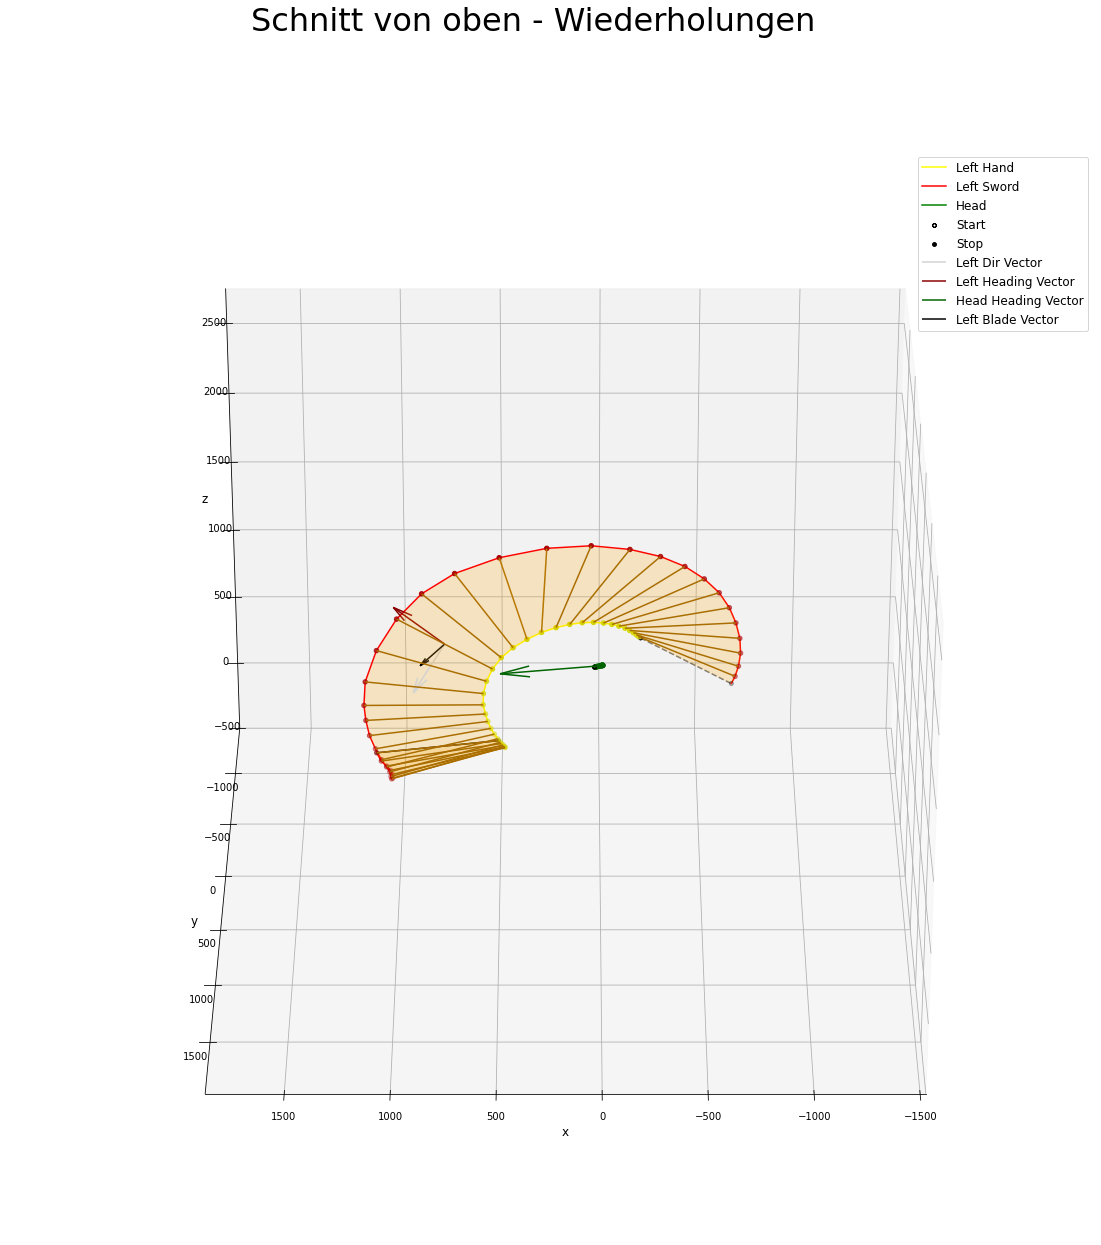

In [69]:
fig = get_figure("Schnitt von oben - Wiederholungen", 20, 1, 1)
# ax = plt.axes(projection="3d")

ax = fig.add_subplot(1, 1, 1, projection="3d")

lims = get_limits(df=df, buffer=500)

start = 200
stop =  235
vector_point = start + ((stop - start) // 2)

start_points = list()
end_points = list()

for s in ["left_hand", "left_sword", "head"]:
    plot_points(df=df, section=s, ax=ax, start=start, stop=stop)
    plot_interval(df=df, section=s, ax=ax, start=start, stop=stop)
    start_points.append(get_marker_data(df=df, section=s, idx=start))
    end_points.append(get_marker_data(df=df, section=s, idx=stop-1))

start_lines = list()
end_lines = list()

for s in ["left_fill"]:
    plot_interval(df=df, section=s, ax=ax, start=start, stop=stop)
    plot_fill(df=df, section=s, ax=ax, start=start, stop=stop)
    start_lines.append(get_marker_data(df=df, section=s, idx=start))
    end_lines.append(get_marker_data(df=df, section=s, idx=stop-1))

plot_start_markers(ax=ax, start_points=start_points, start_lines=start_lines)
plot_stop_markers(ax=ax, end_points=end_points, end_lines=end_lines)

# plot_person(df=df, ax=ax)
for v in [
        "left_dir_vector",
        "left_heading_vector", "head_heading_vector",
        "left_blade_vector"]:

    plot_vector(df=df, ax=ax, section=v, idx=vector_point)

ax.set_xlabel("x", fontsize="large")
ax.set_ylabel("y", fontsize="large")
ax.set_zlabel("z", fontsize="large")

ax.set_xlim(lims["x"])
ax.set_ylim(lims["y"])
ax.set_zlim(lims["z"])

ax.legend(fontsize="large")
ax.view_init(30, 90)

plt.show()

## Check the Correctness of Movements

In [61]:
# log_path_rep = r"AllFiles\Old Files\2024-07-24_new_column_names\log-2024-07-24T132037.csv"

# df_rep = get_log_df(log_file_path=log_path_rep)
# get_movement_by_speed(df=df, threshold=1.25)
# get_movement_ids(df=df, method="max")
# get_movement_indexes(df=df)

log_path_many = r"AllFiles\2024-09-09\log-2024-09-09T061323.csv"

In [62]:
all_results = dict()
# result_cols = list()

for st in [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75]:  # st = speed_threshold
    log = get_log_df(log_path_rep)
    get_movement_by_speed(log, speed_threshold=st)
    for m, col, t in it.product(["avg", "max"], ["sword", "blade"], range(45, 180, 15)):

        res = get_movement_ids(
            df = log,
            results = "dict",
            sections_to_use = ["right"],
            method = m,
            diff_column = col,
            angle_threshold = t)["right_movement"]

        col = f"r{col[0]}_{m}{t}_{int(st*100)}"

        res = [1 if x > 0 else x for x in res]

        all_results[col] = res.copy()
        # result_cols.append(col)

# all_results = all_results[result_cols]
all_res = pd.DataFrame.from_dict(all_results)
all_res.to_clipboard(excel=True, decimal=",")
# all_res.to_csv("tech_movements.csv")

In [68]:
all_summarized = {k: [[x, sum(1 for i in g)] for x, g in it.groupby(all_res[k])] for k in all_res.keys()}

pprint(all_summarized, sort_dicts=False)

{'rs_avg45_75': [[0, 57],
                 [-1, 95],
                 [0, 20],
                 [-1, 40],
                 [0, 62],
                 [-1, 117],
                 [0, 29],
                 [-1, 39],
                 [0, 43],
                 [-1, 108],
                 [0, 7],
                 [-1, 40],
                 [0, 42],
                 [-1, 90],
                 [0, 11],
                 [-1, 35],
                 [0, 33],
                 [-1, 78],
                 [0, 45],
                 [-1, 31],
                 [0, 44],
                 [-1, 87],
                 [0, 25],
                 [-1, 33],
                 [0, 90]],
 'rs_avg60_75': [[0, 57],
                 [-1, 95],
                 [0, 20],
                 [-1, 40],
                 [0, 62],
                 [-1, 117],
                 [0, 29],
                 [-1, 39],
                 [0, 43],
                 [-1, 108],
                 [0, 7],
                 [-1, 40],
                 

In [56]:
value_combinations = list(it.product(
    ["avg", "max"],       # m: method
    [True],               # s: use sword column
    [True],               # b: use blade column
    range(45, 180, 15),   # sat: sword angle threshold
    range(45, 180, 15)))  # bat: blade angle threshold

value_combinations += list(it.product(  # include sword only
    ["avg", "max"],
    [True],
    [False],
    range(45, 180, 15),
    [0]))

value_combinations += list(it.product(  # include blade only
    ["avg", "max"],
    [False],
    [True],
    [0],
    range(45, 180, 15)))

len(value_combinations)

198

In [57]:
def get_movement_ids_test(
        df: pd.DataFrame,
        results: Literal["insert", "dict", "create"] = "insert",
        sections_to_use: list = ["left", "right"],
        method: Literal["avg", "max"] = "avg",
        use_sword_column: bool = True,
        use_blade_column: bool = True,
        sword_angle_threshold: int = 60,
        blade_angle_threshold: int = 60,
        do_prints: bool = False):

    results_dict = dict()

    for seg in sections_to_use:
        cmid = 1  # current movement id
        alls = [[k, sum(1 for i in g)] for k, g in it.groupby(df[f"{seg}_speed"].to_list())]
        result = list()

        diff_columns = list()

        if use_blade_column:
            diff_columns.append(("blade", blade_angle_threshold))
        if use_sword_column:
            diff_columns.append(("sword", sword_angle_threshold))

        for (diff_column, angle_threshold) in diff_columns:

            res = list()
            for [m, c] in alls:
                i = len(res) - 1
                if m:
                    angles = df.iloc[i:i+c][f"{seg}_{diff_column}_euler_diff"].to_list()
                    if method == "avg":
                        if sum(angles) / len(angles) < angle_threshold:
                            res += [cmid] * c
                        else:
                            res += [-1] * c  # is change
                    if method == "max":
                        if max(angles) < angle_threshold:
                            res += [cmid] * c
                        else:
                            res += [-1] * c  # is change   
                else:
                    if len(res) and res[-1] > 0:
                        cmid += 1
                    res += [0] * c

            if len(result) == 0:
                result += res
            else:
                result = [x and y for x, y in zip(result, res)]


        results_dict[f"{seg}_movement"] = result

        if results == "insert":
            df[f"{seg}_movement"] = result

        if do_prints:
            print(f"found {cmid} movements in {seg}")

    if results == "create":
        result = pd.DataFrame(results_dict)
        return result
    elif results == "dict":
        return results_dict
    else:
        return df

In [58]:
all_results = dict()
# result_cols = list()

for st in [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]:  # st = speed_threshold

    log = get_log_df(log_path_rep)
    get_movement_by_speed(log, speed_threshold = st)

    for (m, s, b, sat, bat) in value_combinations:

        res_dict = get_movement_ids_test(
            df = log,
            results = "dict",
            sections_to_use = ["left", "right"],
            use_sword_column = s,
            use_blade_column = b,
            sword_angle_threshold = sat,
            blade_angle_threshold = bat)
        
        res1 = res_dict["left_movement"]
        res2 = res_dict["right_movement"]

        res1 = [1 if x > 0 else x for x in res1]
        res2 = [1 if x > 0 else x for x in res2]

        st_text = f"{st}".replace(".", "x")
        col1 = f"l_s{sat}_b{bat}_{m}_{st_text}"
        col2 = f"r_s{sat}_b{bat}_{m}_{st_text}"

        # print(col1, col2)

        all_results[col1] = res1.copy()
        all_results[col2] = res2.copy()

all_res = pd.DataFrame.from_dict(all_results)
all_res.to_clipboard(excel=True, decimal=",")
# all_res.to_csv("tech_movements.csv")

l_s45_b45_avg_1x0 r_s45_b45_avg_1x0
l_s45_b60_avg_1x0 r_s45_b60_avg_1x0
l_s45_b75_avg_1x0 r_s45_b75_avg_1x0
l_s45_b90_avg_1x0 r_s45_b90_avg_1x0
l_s45_b105_avg_1x0 r_s45_b105_avg_1x0
l_s45_b120_avg_1x0 r_s45_b120_avg_1x0
l_s45_b135_avg_1x0 r_s45_b135_avg_1x0
l_s45_b150_avg_1x0 r_s45_b150_avg_1x0
l_s45_b165_avg_1x0 r_s45_b165_avg_1x0
l_s60_b45_avg_1x0 r_s60_b45_avg_1x0
l_s60_b60_avg_1x0 r_s60_b60_avg_1x0
l_s60_b75_avg_1x0 r_s60_b75_avg_1x0
l_s60_b90_avg_1x0 r_s60_b90_avg_1x0
l_s60_b105_avg_1x0 r_s60_b105_avg_1x0
l_s60_b120_avg_1x0 r_s60_b120_avg_1x0
l_s60_b135_avg_1x0 r_s60_b135_avg_1x0
l_s60_b150_avg_1x0 r_s60_b150_avg_1x0
l_s60_b165_avg_1x0 r_s60_b165_avg_1x0
l_s75_b45_avg_1x0 r_s75_b45_avg_1x0
l_s75_b60_avg_1x0 r_s75_b60_avg_1x0
l_s75_b75_avg_1x0 r_s75_b75_avg_1x0
l_s75_b90_avg_1x0 r_s75_b90_avg_1x0
l_s75_b105_avg_1x0 r_s75_b105_avg_1x0
l_s75_b120_avg_1x0 r_s75_b120_avg_1x0
l_s75_b135_avg_1x0 r_s75_b135_avg_1x0
l_s75_b150_avg_1x0 r_s75_b150_avg_1x0
l_s75_b165_avg_1x0 r_s75_b165_avg_1x

In [66]:
df.adjusted_timestamp.to_clipboard(excel=True, decimal=",")

### Compare Accuracy

In [55]:
correct_movement = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   # 100

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,   # 200

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,  # 300

    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 400

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,   # 500

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,   # 600

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 700

    0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 800

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,   # 900

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,   # 1000

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,   # 1100

    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 1200

   -1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 1300

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 1400

   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
   -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 1500

    1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 1600

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
tech_correct_movement = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,

    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,   # 200

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,   # 400

    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 600

    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 800

    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 1000

    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

    0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   # 1200

    0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,  # 1400

    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,
    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  # 1600

    -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0]

In [93]:
df_correct_movement= [
    0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  
    0,   0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 
    -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  
    0,   0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
    1,   1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, 

    -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 
    -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  
    1,   1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  
    0,   0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 
    -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  

    0,   0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
    1,   1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, 
    -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 
    -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  
    1,   1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  

    1,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  
    0,   0]

In [ ]:
res_cols, res_lists = list(all_results.keys()), list(all_results.values())

matching_points_list = list()
for i in range(df.shape[0]):
    correct = df_correct_movement[i]
    matching_points_list.append([l[i] == correct for l in res_lists])

matchings = points_to_columns(matching_points_list)
accuracy_list = [sum(m) / len(m) for m in matchings]

accuracy = pd.DataFrame({"method": res_cols, "accuracy": accuracy_list})
accuracy.sort_values(by="accuracy", ascending=False, inplace=True)

regex = "[lr]_s(\d+)_b(\d+)\_([a-z]+)_(\d+)_(\d+x\d+)"
re_results = list()
for k, v in accuracy.itertuples(index=False):
    el = re.match(regex, k)
    re_results.append(list(el.groups()))
    print(f"{k:>22}: {v * 100:.4f}% accuracy")

regex_results = points_to_columns(re_results)

In [104]:
colnames = ["sword_angle_threshold", "blade_angle_threshold", "angle_method", "points_threshold", "speed_threshold"]
values_dict = {k: list(set(v)) for k, v in zip(colnames, regex_results)}

score_dict = {k: dict() for k in values_dict.keys()}

for k, vl in values_dict.items():
    score_dict[k] = {v: 0 for v in vl}

reg_dict = {k: v for k, v in zip(colnames, regex_results)}

for col, val in reg_dict.items():
    for i in range(len(val)):
        score_dict[col][val[i]] += 1 / (i + 1)
    for i in range(20):
        score_dict[col][val[i]] += 1

# print(score_dict)

rank_dict = dict()

for col, inner_dict in score_dict.items():
    rank_dict[col] = sorted(list(inner_dict.items()), key = lambda k: k[1], reverse=True)

print(rank_dict)

{'sword_angle_threshold': [('135', 9.91031387837726), ('150', 9.772240658307227), ('75', 2.425637219701363), ('165', 2.0213096018997576), ('120', 1.5701702612951238), ('60', 0.6375813095210727), ('45', 0.5882365503401451), ('105', 0.4058097225149339), ('90', 0.3952789225935076), ('', 0.3364097057534266)], 'blade_angle_threshold': [('45', 6.054125878819994), ('150', 2.901554288588126), ('135', 2.7837488441910434), ('120', 2.7481796633057956), ('105', 2.6831594226817446), ('90', 2.6584307038274133), ('75', 2.649434685496854), ('60', 2.633942074302258), ('165', 2.5972682183092983), ('', 0.35314405078129)], 'angle_method': [('avg', 23.901779549869275), ('max', 4.161208280434531)], 'speed_threshold': [('1x75', 25.868005822493306), ('2x0', 0.6918861485173151), ('2x25', 0.4050445279138835), ('2x5', 0.28747173807070053), ('2x75', 0.2230173365146868), ('1x5', 0.1822374076897393), ('1x25', 0.15409057043223032), ('1x0', 0.13348630899667957), ('0x75', 0.11774796967527767)]}


In [112]:
hand_confintv = (df.left_hand_speed.quantile(0.75) + df.right_hand_speed.quantile(0.75)) / 2
sword_confintv = (df.left_sword_speed.quantile(0.75) + df.right_sword_speed.quantile(0.75)) / 2

print(hand_confintv, sword_confintv)

1.878625 5.47225


In [66]:
get_movement_by_speed(df, speed_threshold=1.25)
alls = [[k, sum(1 for i in g)] for k, g in it.groupby(df[f"left_speed"].to_list())]
# print(alls)

i = 0
movement_statistics = dict()

for n in range(len(alls)):
    movement, length = alls[n]
    hand = df.left_hand_speed.to_list()[i:i+length]
    sword = df.left_sword_speed.to_list()[i:i+length]
    hand_min, hand_max, hand_avg = min(hand), max(hand), sum(hand) / float(len(hand))
    sword_min, sword_max, sword_avg = min(sword), max(sword), sum(sword) / float(len(sword))
    movement_statistics[n] = {
        "movement_type": movement,
        "movement_length": length,
        "hand_min": hand_min,
        "hand_max": hand_max,
        "hand_avg": hand_avg,
        "sword_min": sword_min,
        "sword_max": sword_max,
        "sword_avg": sword_avg}

    i += length

movs = pd.DataFrame.from_dict(movement_statistics, orient="index")

movs

,movement_type,movement_length,hand_min,hand_max,hand_avg,sword_min,sword_max,sword_avg
0,0,28,0.091,1.1,0.3026071428571428,0.245,1.725,0.7296785714285715
1,1,28,1.182,9.923,3.314607142857143,1.902,26.819,8.638714285714284
2,0,10,0.245,1.241,0.6959000000000002,0.735,3.131,2.1412999999999998
3,1,59,0.412,10.195,4.911084745762708,2.265,24.107,12.361694915254233
4,0,7,0.273,1.208,0.7732857142857144,0.632,4.099,2.3804285714285713
5,1,61,0.248,9.698,4.867967213114755,1.758,25.017,12.223770491803277
6,0,7,0.375,1.199,0.8205714285714285,0.663,3.862,2.0460000000000003
7,1,65,0.539,9.689,4.724446153846151,1.342,26.374,11.919892307692308
8,0,10,0.328,1.202,0.7505,0.68,3.794,1.9135000000000002
9,1,28,1.474,9.672,5.307571428571428,1.892,25.113,12.81382142857143


## Visualization

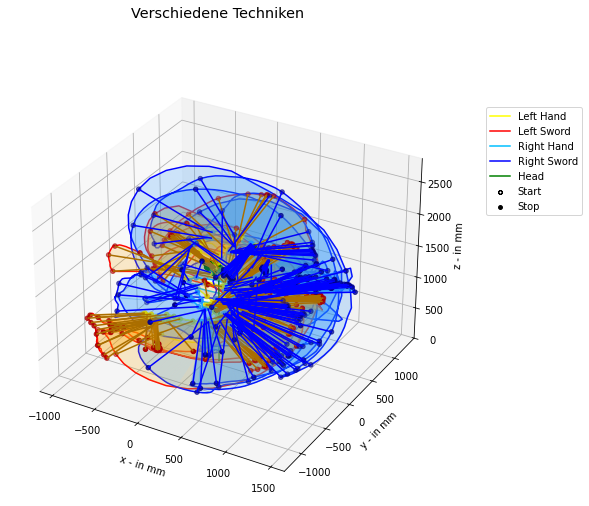

In [56]:
# FULL VISUALIZATION

show_3d_plot(df=dfa, title="Verschiedene Techniken", start = 0, stop = 2222)

In [128]:
dfm = get_log_df(log_file_path=log_path_many)

get_movement_by_speed(df=dfm, speed_threshold=1.25)
get_movement_ids(df=dfm, method="max")
get_movement_indexes(df=dfm)

,movement,count,start_index,end_index,length,time
0,0,70,0,70,70,0.7
1,-1,62,70,132,62,0.62
2,0,31,132,163,31,0.31
3,1,32,163,195,32,0.32
4,0,97,195,292,97,0.97
5,-1,65,292,357,65,0.65
6,0,30,357,387,30,0.3
7,-1,34,387,421,34,0.34
8,0,150,421,571,150,1.5
9,-1,44,571,615,44,0.44


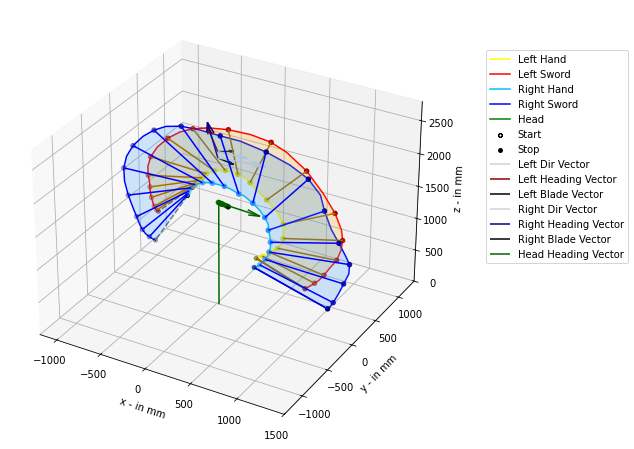

In [125]:
# SINGLE TECHNIQUE - 3D

show_3d_plot(df=dfm, title="", start=170, stop=205, include_vectors=True, interval=2)

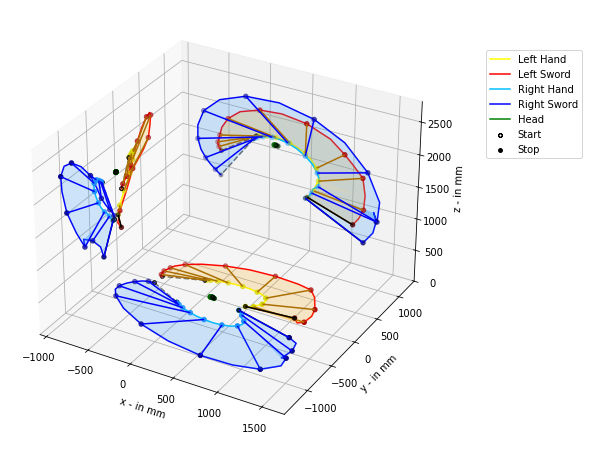

In [136]:
# SINGLE TECHNIQUE - CONTOUR
# ys = ["left_hand_y", "left_sword_y", "right_hand_y", "right_sword_y", "head_y"]
# for y in ys:
#     dfm[y] = dfm[y].apply(lambda x: -x)

show_contour_plot(df=dfm, title="", start=386, stop=407, interval=2)

In [85]:
points = dict()
for s in ["right_hand", "right_sword", "left_hand", "left_sword", "head"]:
    section_columns = get_data(df, s, start=160, stop=192)
    section_x = section_columns[0].copy()
    section_z = section_columns[2].copy()
    points[f"{s}_x"] = section_x
    points[f"{s}_z"] = section_z
    points[s] = list(zip(section_x, section_z))

In [88]:
points_df = pd.DataFrame.from_dict(points)
points_df.to_clipboard(excel=True, decimal=",")

### Speed Boxplot

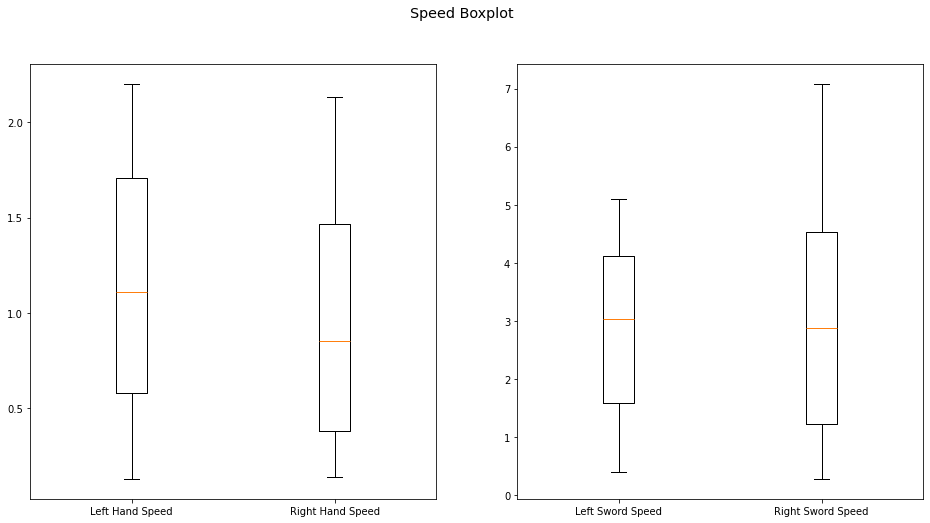

In [77]:
fig = get_figure("Speed Boxplot", 8, 1, 2)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax4 = fig.add_subplot(2, 2, 4)

# for ax, sec in zip(
#         [ax1, ax2, ax3, ax4],
#         ["left_hand", "right_hand", "left_sword", "right_sword"]):

#     ax.set_title(to_text(sec))
#     ax.boxplot(df[f"{sec}_speed"].to_list(), showfliers=False)

# fig = plt.figure(figsize=(15, 15), layout="constrained")
# ax = plt.axes()

hand_cols = ["left_hand_speed", "right_hand_speed"]
sword_cols = ["left_sword_speed", "right_sword_speed"]
# cols = get_columns(df=df, columns="speed", returns="names")

hand_dat = [df[c].to_list()[275:303] for c in hand_cols]
ax1.boxplot(hand_dat, showfliers=False, tick_labels=[to_text(c) for c in hand_cols])
sword_dat = [df[c].to_list()[275:303] for c in sword_cols]
ax2.boxplot(sword_dat, showfliers=False, tick_labels=[to_text(c) for c in sword_cols])


plt.show()

### Variable Comparisons

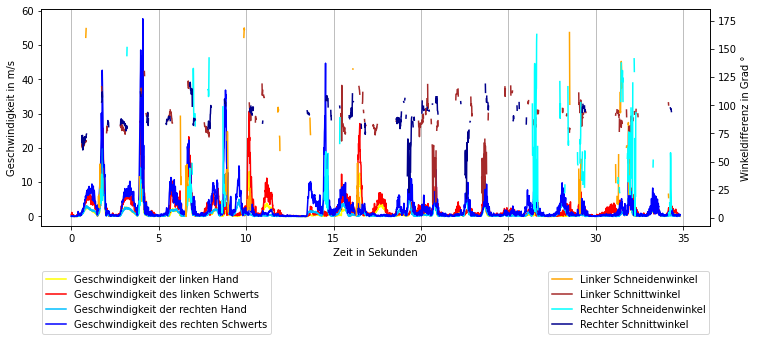

In [63]:
dfm = get_log_df(log_path_many)

fig, ax = plt.subplots(figsize=(12, 4))
# fig.suptitle("Gemischte Techniken", fontsize=14)

show_comparison(df=dfm, ax_left=ax, variables_left=ALL_SPEEDS, variables_right=ALL_EULER, legend_position="below")
# plot_variables_comparison(df=dfm, ax=ax, variables_1 = all_speeds, variables_2=all_euler, legend_position="below")

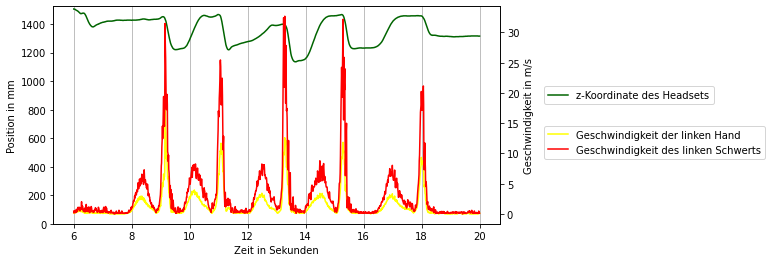

In [67]:
dfh = get_log_df(log_file_path=log_path_h)
fig, ax = plt.subplots(figsize=(8, 4))

show_comparison(df=dfh, ax_left=ax, variables_left="head_z", variables_right="left_speed", start=600)

# plot_variable_comparison(df=df, ax=ax, variable_left = "head", variable_right = "left_speed")

In [68]:
pprint(dfh.head_z.to_list()[650:], compact=True)

[1419.0, 1415.0, 1411.0, 1408.0, 1404.0, 1400.0, 1397.0, 1394.0, 1391.0, 1389.0,
 1387.0, 1385.0, 1383.0, 1382.0, 1381.0, 1381.0, 1381.0, 1381.0, 1381.0, 1382.0,
 1383.0, 1384.0, 1386.0, 1387.0, 1389.0, 1390.0, 1392.0, 1393.0, 1394.0, 1395.0,
 1396.0, 1397.0, 1398.0, 1399.0, 1399.0, 1400.0, 1402.0, 1402.0, 1403.0, 1404.0,
 1405.0, 1406.0, 1407.0, 1408.0, 1409.0, 1409.0, 1410.0, 1411.0, 1411.0, 1412.0,
 1413.0, 1413.0, 1413.0, 1414.0, 1414.0, 1415.0, 1415.0, 1416.0, 1416.0, 1417.0,
 1417.0, 1418.0, 1419.0, 1419.0, 1420.0, 1420.0, 1420.0, 1421.0, 1421.0, 1421.0,
 1421.0, 1421.0, 1421.0, 1421.0, 1421.0, 1421.0, 1421.0, 1421.0, 1421.0, 1421.0,
 1421.0, 1421.0, 1421.0, 1422.0, 1422.0, 1422.0, 1423.0, 1423.0, 1423.0, 1424.0,
 1424.0, 1425.0, 1425.0, 1426.0, 1426.0, 1427.0, 1427.0, 1427.0, 1428.0, 1428.0,
 1428.0, 1428.0, 1428.0, 1428.0, 1428.0, 1428.0, 1428.0, 1428.0, 1428.0, 1428.0,
 1428.0, 1427.0, 1427.0, 1427.0, 1427.0, 1427.0, 1427.0, 1427.0, 1426.0, 1426.0,
 1426.0, 1426.0, 1426.0, 142

In [226]:
speeds_sword_left = df.left_sword_speed.to_list()
speeds_sword_right = df.right_sword_speed.to_list()
speeds_hand_left = df.left_hand_speed.to_list()
speeds_hand_right = df.right_hand_speed.to_list()

intervals = [(150, 200), (400, 450), (600, 650), (775, 825), (975, 1025), (1175, 1225)]

cuts = {
    "left_sword": [speeds_sword_left[i:j] for (i, j) in intervals],
    "right_sword": [speeds_sword_right[i:j] for (i, j) in intervals],
    "left_hand": [speeds_hand_left[i:j] for (i, j) in intervals],
    "right_hand": [speeds_hand_right[i:j] for (i, j) in intervals]}

maximums = {
    "left_sword": [max(li) for li in cuts["left_sword"]],
    "right_sword": [max(li) for li in cuts["right_sword"]],
    "left_hand": [max(li) for li in cuts["left_hand"]],
    "right_hand": [max(li) for li in cuts["right_hand"]]}

avg = {
    "left_sword": round(sum(maximums["left_sword"]) / 6, 2),
    "right_sword": round(sum(maximums["right_sword"]) / 6, 2),
    "both_swords": round((sum(maximums["left_sword"]) + sum(maximums["right_sword"])) / 12, 2),
    "left_hand": round(sum(maximums["left_hand"]) / 6, 2),
    "right_hand": round(sum(maximums["right_hand"]) / 6, 2),
    "both_hands": round((sum(maximums["left_hand"]) + sum(maximums["right_hand"])) / 12, 2)}

pprint(maximums)
pprint(avg)

{'left_hand': [21.679, 17.708, 12.021, 14.826, 14.033, 12.681],
 'left_sword': [32.617, 30.989, 27.529, 32.208, 31.248, 26.291],
 'right_hand': [13.261, 12.507, 11.629, 13.179, 13.179, 11.501],
 'right_sword': [30.547, 37.285, 33.894, 36.603, 35.435, 29.856]}
{'both_hands': 14.02,
 'both_swords': 32.04,
 'left_hand': 15.49,
 'left_sword': 30.15,
 'right_hand': 12.54,
 'right_sword': 33.94}


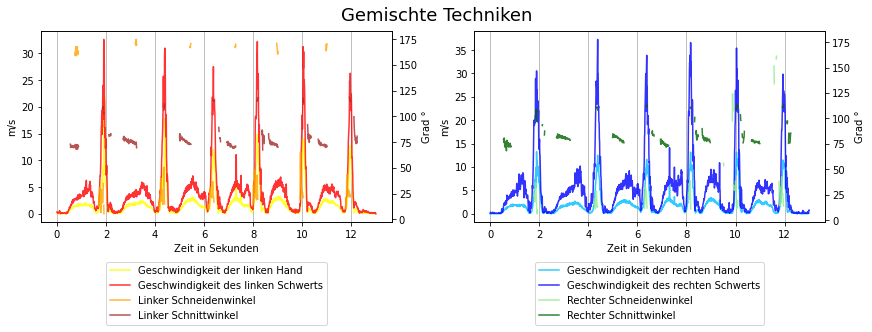

In [117]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 4.5), layout="constrained")
fig.suptitle("Gemischte Techniken", fontsize=18)

plot_variable_comparison(df=df, ax=ax_1, variable_left = "left_speed", variable_right = "left_euler", legend_position="below-stacked")
plot_variable_comparison(df=df, ax=ax_2, variable_left = "right_speed", variable_right = "right_euler", legend_position="below-stacked")

In [100]:
xax = ax_1.get_xaxis()

xax.get_major_formatter()

In [102]:
ax_1.get_xbound()

(-1.74055, 36.55155)

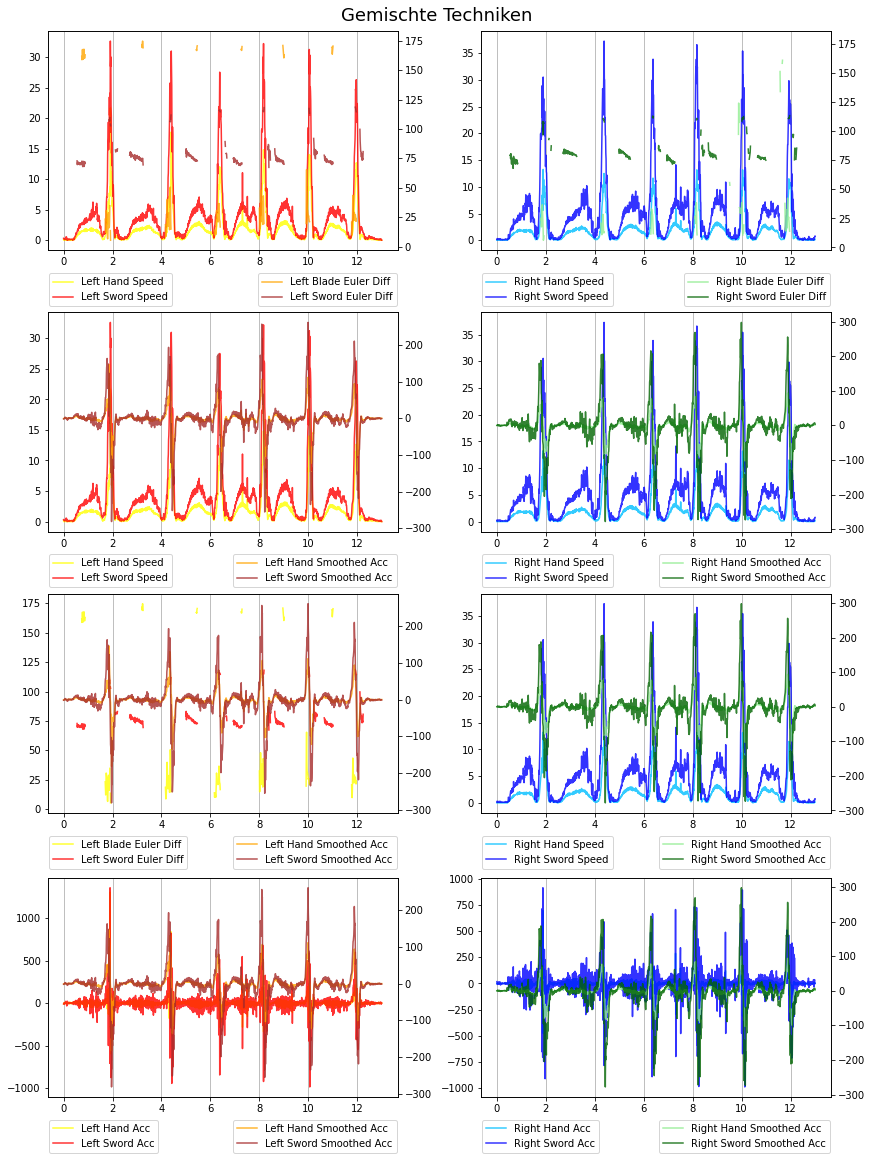

In [197]:
fig, ((ax_1, ax_2), (ax_3, ax_4), (ax_5, ax_6), (ax_7, ax_8)) = plt.subplots(4, 2, figsize=(12, 16), layout="constrained")
fig.suptitle("Gemischte Techniken", fontsize=18)

left_speed = ["left_hand_speed", "left_sword_speed"]
right_speed = ["right_hand_speed", "right_sword_speed"]
left_acc = ["left_hand_acc", "left_sword_acc"]
right_acc = ["right_hand_acc", "right_sword_acc"]
left_smoothed_acc = ["left_hand_smoothed_acc", "left_sword_smoothed_acc"]
right_smoothed_acc = ["right_hand_smoothed_acc", "right_sword_smoothed_acc"]
left_euler = ["left_blade_euler_diff", "left_sword_euler_diff"]
right_euler = ["right_blade_euler_diff", "right_sword_euler_diff"]

plot_variable_comparison(df=df, ax=ax_1, variables_1 = left_speed, variables_2 = left_euler, legend_position="below")
plot_variable_comparison(df=df, ax=ax_2, variables_1 = right_speed, variables_2 = right_euler, legend_position="below")

plot_variable_comparison(df=df, ax=ax_3, variables_1 = left_speed, variables_2 = left_smoothed_acc, legend_position="below")
plot_variable_comparison(df=df, ax=ax_4, variables_1 = right_speed, variables_2 = right_smoothed_acc, legend_position="below")

plot_variable_comparison(df=df, ax=ax_5, variables_1 = left_euler, variables_2 = left_smoothed_acc, legend_position="below")
plot_variable_comparison(df=df, ax=ax_6, variables_1 = right_speed, variables_2 = right_smoothed_acc, legend_position="below")

plot_variable_comparison(df=df, ax=ax_7, variables_1 = left_acc, variables_2 = left_smoothed_acc, legend_position="below")
plot_variable_comparison(df=df, ax=ax_8, variables_1 = right_acc, variables_2 = right_smoothed_acc, legend_position="below")

plt.show()

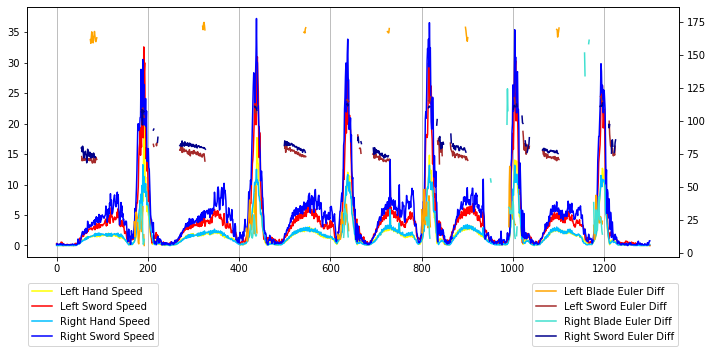

In [172]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

plot_variable_comparison(df=df, ax=ax, variables_1 = left_speed + right_speed, variables_2 = left_euler + right_euler, legend_position="below")

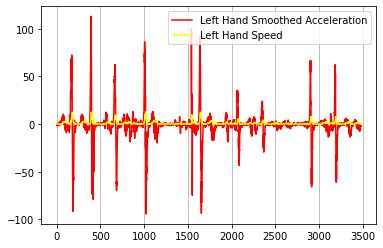

In [167]:
fig, ax = plt.subplots()

ax.plot(dfm.left_hand_smoothed_acc.to_list(), color="red", label = "Left Hand Smoothed Acceleration")
ax.plot(dfm.left_hand_speed.to_list(), color="yellow", label = "Left Hand Speed")
ax.grid(True, axis="x")
ax.legend()
plt.show()

In [ ]:
all_dat = dict()

for var in ALL_VAR:
    all_dat[var] = dfm[var].to_list()

var_colors = {
    "left_hand_speed": "yellow",
    "left_sword_speed": "red",
    "right_hand_speed": "deepskyblue",
    "right_sword_speed": "dodgerblue",
    "left_blade_euler_diff": "brown",
    "left_sword_euler_diff": "orange",
    "right_blade_euler_diff": "darkgreen",
    "right_sword_euler_diff": "lightgreen"}

fig, ax_speed = plt.subplots()
ax_euler = ax_speed.twinx()

for speed_col in ["left_hand_speed", "left_sword_speed", "right_hand_speed", "right_sword_speed"]:
    ax_speed.plot(all_dat[speed_col], label=to_text(speed_col), color=var_colors[speed_col])

for euler_col in ["left_blade_euler_diff", "left_sword_euler_diff", "right_blade_euler_diff", "right_sword_euler_diff"]:
    ax_euler.plot(all_dat[euler_col], label=to_text(euler_col), color=var_colors[euler_col])

ax_speed.legend(bbox_to_anchor=(1.1, 0.55), loc="lower left", borderaxespad=0.)
ax_euler.legend(bbox_to_anchor=(1.1, 0.45), loc="upper left", borderaxespad=0.)

plt.show()

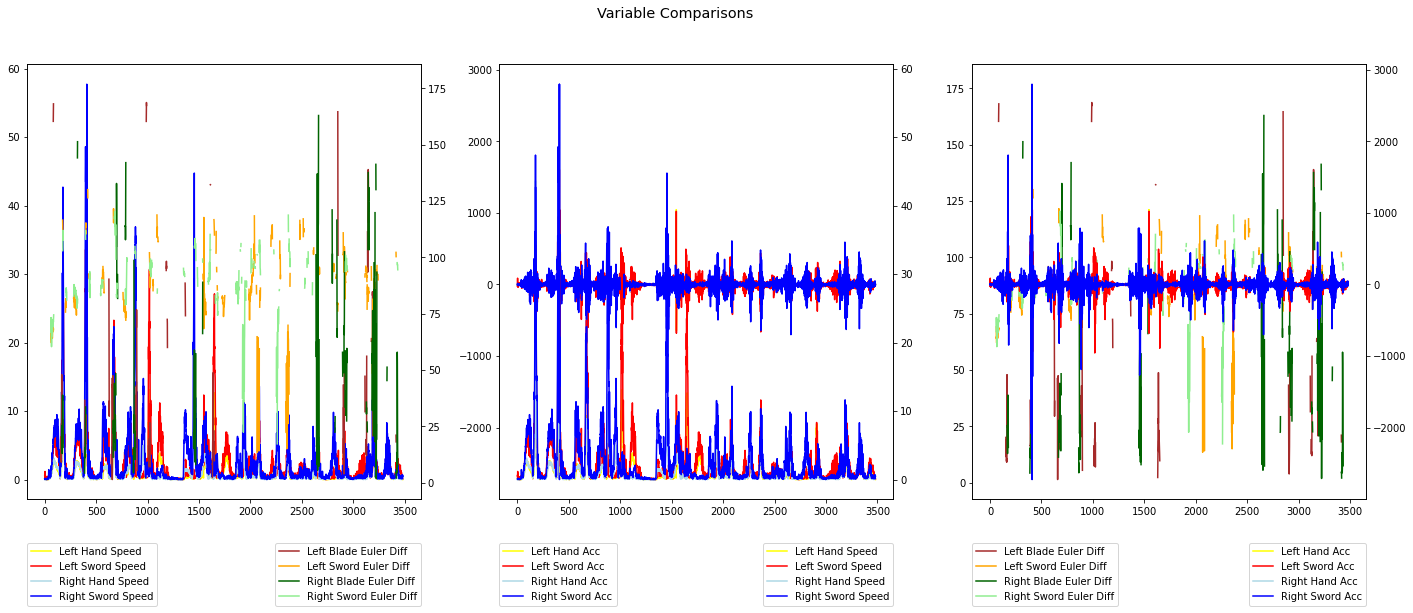

In [ ]:
dfm = get_log_df(log_path_many)

ALL_SPEEDS = [
    "left_hand_speed",
    "left_sword_speed", 
    "right_hand_speed", 
    "right_sword_speed"]

ALL_ACC = [
    "left_hand_acc",
    "left_sword_acc", 
    "right_hand_acc", 
    "right_sword_acc"]

ALL_SMOOTHED_ACC = [
    "left_hand_smoothed_acc",
    "left_sword_smoothed_acc", 
    "right_hand_smoothed_acc", 
    "right_sword_smoothed_acc"]

ALL_EULER = [ 
    "left_blade_euler_diff", 
    "left_sword_euler_diff", 
    "right_blade_euler_diff", 
    "right_sword_euler_diff"]

ALL_VAR = ALL_SPEEDS + ALL_EULER + ALL_ACC

all_dat = dict()

for var in ALL_VAR:
    all_dat[var] = dfm[var].to_list()

var_colors = {
    "left_hand_speed": "yellow",
    "left_sword_speed": "red",
    "right_hand_speed": "lightblue",
    "right_sword_speed": "blue",
    "left_blade_euler_diff": "brown",
    "left_sword_euler_diff": "orange",
    "right_blade_euler_diff": "darkgreen",
    "right_sword_euler_diff": "lightgreen",
    "left_hand_acc": "yellow",
    "left_sword_acc": "red",
    "right_hand_acc": "lightblue",
    "right_sword_acc": "blue",
    "left_hand_smoothed_acc": "brown",
    "left_sword_smoothed_acc": "orange",
    "right_hand_smoothed_acc": "darkgreen",
    "right_sword_smoothed_acc": "lightgreen"}

fig = get_figure("Variable Comparisons", 8, 1, 3)

ax_11 = fig.add_subplot(1, 3, 1)    # SPEED and euler
ax_21 = fig.add_subplot(1, 3, 2)    # ACC and speed
ax_31 = fig.add_subplot(1, 3, 3)    # EULER and acc

ax_12 = ax_11.twinx()   # speed and EULER
ax_22 = ax_21.twinx()   # acc and SPEED
ax_32 = ax_31.twinx()   # euler and ACC


for speed_col in ALL_SPEEDS:
    ax_11.plot(all_dat[speed_col], label=to_text(speed_col), color=var_colors[speed_col])
    ax_22.plot(all_dat[speed_col], label=to_text(speed_col), color=var_colors[speed_col])

for euler_col in ALL_EULER:
    ax_12.plot(all_dat[euler_col], label=to_text(euler_col), color=var_colors[euler_col])
    ax_31.plot(all_dat[euler_col], label=to_text(euler_col), color=var_colors[euler_col])

for acc_col in ALL_ACC:
    ax_21.plot(all_dat[acc_col], label=to_text(acc_col), color=var_colors[acc_col])
    ax_32.plot(all_dat[acc_col], label=to_text(acc_col), color=var_colors[acc_col])


ax_11.legend(bbox_to_anchor=(0., -0.1), loc="upper left", borderaxespad=0.)
ax_12.legend(bbox_to_anchor=(1., -0.1), loc="upper right", borderaxespad=0.)
ax_21.legend(bbox_to_anchor=(0., -0.1), loc="upper left", borderaxespad=0.)
ax_22.legend(bbox_to_anchor=(1., -0.1), loc="upper right", borderaxespad=0.)
ax_31.legend(bbox_to_anchor=(0., -0.1), loc="upper left", borderaxespad=0.)
ax_32.legend(bbox_to_anchor=(1., -0.1), loc="upper right", borderaxespad=0.)

plt.show()

## Movements

In [ ]:
def identify_movement_types(df: pd.DataFrame):

    # if break: movement speed is near zero.
    # if cut: blade and movement vector should be near aligned; maximal speed
    # if change: blade and movement vector should be near perfect opposites, speed can vary

    hand_confintv = (df.left_hand_speed.quantile(0.75) + df.right_hand_speed.quantile(0.75)) / 2
    sword_confintv = (df.left_sword_speed.quantile(0.75) + df.right_sword_speed.quantile(0.75)) / 2

    print(hand_confintv, sword_confintv)

In [114]:
movements = [[k, sum(1 for i in g)] for k, g in it.groupby(correct_movement)]

all_sections = list()
all_movements = list()
all_cuts = list()

i = 0

for [m, c] in movements:

    all_sections.append([m, i, i + c])

    if m == 1:
        all_cuts.append([i, i + c])
    
    if m != 0:
        all_movements.append([m, i, i + c])
    i += c

all_sections


[[0, 0, 164],
 [1, 164, 192],
 [0, 192, 230],
 [1, 230, 259],
 [0, 259, 318],
 [1, 318, 367],
 [0, 367, 394],
 [1, 394, 419],
 [0, 419, 473],
 [1, 473, 522],
 [0, 522, 549],
 [1, 549, 574],
 [0, 574, 630],
 [1, 630, 674],
 [0, 674, 698],
 [1, 698, 720],
 [0, 720, 775],
 [1, 775, 820],
 [0, 820, 846],
 [1, 846, 871],
 [0, 871, 925],
 [1, 925, 971],
 [0, 971, 1000],
 [1, 1000, 1026],
 [0, 1026, 1114]]

In [ ]:
fig = get_figure("Alle Techniken", 20, 11, 2)
# ax = plt.axes(projection="3d")

ax1  = fig.add_subplot(11, 2, 1, projection="3d")
ax2  = fig.add_subplot(11, 2, 2, projection="3d")
ax3  = fig.add_subplot(11, 2, 3, projection="3d")
ax4  = fig.add_subplot(11, 2, 4, projection="3d")
ax5  = fig.add_subplot(11, 2, 5, projection="3d")
ax6  = fig.add_subplot(11, 2, 6, projection="3d")
ax7  = fig.add_subplot(11, 2, 7, projection="3d")
ax8  = fig.add_subplot(11, 2, 8, projection="3d")
ax9  = fig.add_subplot(11, 2, 9, projection="3d")
ax10 = fig.add_subplot(11, 2, 10, projection="3d")
ax11 = fig.add_subplot(11, 2, 11, projection="3d")
ax12 = fig.add_subplot(11, 2, 12, projection="3d")
ax13 = fig.add_subplot(11, 2, 13, projection="3d")
ax14 = fig.add_subplot(11, 2, 14, projection="3d")
ax15 = fig.add_subplot(11, 2, 15, projection="3d")
ax16 = fig.add_subplot(11, 2, 16, projection="3d")
ax17 = fig.add_subplot(11, 2, 17, projection="3d")
ax18 = fig.add_subplot(11, 2, 18, projection="3d")
ax19 = fig.add_subplot(11, 2, 19, projection="3d")
ax20 = fig.add_subplot(11, 2, 20, projection="3d")
ax21 = fig.add_subplot(11, 2, 21, projection="3d")
ax22 = fig.add_subplot(11, 2, 22, projection="3d")

axs = [
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8,
    ax9, ax10, ax11, ax12, ax13, ax14, ax15,
    ax16, ax17, ax18, ax19, ax20, ax21, ax22]

lims = get_limits(df=df, buffer=500)

for i in range(22):

    ax = axs[i]
    movement_type, start, stop = all_movements[i]
    # start -= 10
    # stop += 10

    vector_point = start + ((stop - start) // 2)

    start_points = list()
    end_points = list()

    for s in ["right_hand", "right_sword", "left_hand", "left_sword", "head"]:
        plot_points(df=df, section=s, ax=ax, start=start, stop=stop)
        plot_interval(df=df, section=s, ax=ax, start=start, stop=stop, points_between=5)
        start_points.append(get_marker_data(df=df, section=s, idx=start))
        end_points.append(get_marker_data(df=df, section=s, idx=stop-1))

    start_lines = list()
    end_lines = list()

    for s in ["left_fill", "right_fill"]:
        plot_interval(df=df, section=s, ax=ax, start=start, stop=stop, points_between=5)
        plot_fill(df=df, section=s, ax=ax, start=start, stop=stop)
        start_lines.append(get_marker_data(df=df, section=s, idx=start))
        end_lines.append(get_marker_data(df=df, section=s, idx=stop-1))

    plot_start_markers(ax=ax, start_points=start_points, start_lines=start_lines)
    plot_stop_markers(ax=ax, end_points=end_points, end_lines=end_lines)

    # plot_person(df=df, ax=ax)
    # for v in [
    #         "left_dir_vector", "right_dir_vector",
    #         "left_heading_vector", "right_heading_vector", "head_heading_vector",
    #         "left_blade_vector", "right_blade_vector"]:

    #     plot_vector(df=df, ax=ax, section=v, idx=vector_point)

    ax.set_xlabel("x", fontsize="large")
    ax.set_ylabel("y", fontsize="large")
    ax.set_zlabel("z", fontsize="large")

    ax.set_xlim(lims["x"])
    ax.set_ylim(lims["y"])
    ax.set_zlim(lims["z"])

    ax.set_title(f"{movement_type}: {start} - {stop}")
    ax.view_init(30, 270)

    ax.legend(fontsize="large")

# plt.show()

In [ ]:
log_path_tech = r"AllFiles\Old Files\2024-07-24_new_column_names\log-2024-07-24T132105.csv"
df_tech = get_log_df(log_file_path=log_path_tech)
get_movement_by_speed(df=df_tech, threshold=1.25)
get_movement_ids(df=df_tech, method="max")
get_movement_indexes(df=df_tech)

fig = get_figure("Alle Techniken", 20, 5, 2)
# ax = plt.axes(projection="3d")

lims = get_limits(df=df_tech, buffer=500)

for i in range(10):

    ax = fig.add_subplot(5, 2, i + 1, projection="3d")
    movement_type, start, stop = all_sections[i]
    start = max(0, start - 5)
    stop = min(1662, stop + 5)
    # start -= 10
    # stop += 10

    vector_point = start + ((stop - start) // 2)

    start_points = list()
    end_points = list()

    for s in ["right_hand", "right_sword", "left_hand", "left_sword", "head"]:
        plot_contour_points(df=df_tech, section=s, ax=ax, start=start, stop=stop, limits=lims)
        plot_contour_interval(df=df_tech, section=s, ax=ax, start=start, stop=stop, points_between=5, limits=lims)
        start_points += get_contour_marker_data(df=df_tech, section=s, idx=start, limits=lims)
        end_points += get_contour_marker_data(df=df_tech, section=s, idx=stop-1, limits=lims)

    start_lines = list()
    end_lines = list()

    for s in ["left_fill", "right_fill"]:
        plot_contour_interval(df=df_tech, section=s, ax=ax, start=start, stop=stop, points_between=5, limits=lims)
        plot_contour_fill(df=df_tech, section=s, ax=ax, start=start, stop=stop, limits=lims)
        start_lines.append(get_contour_marker_data(df=df_tech, section=s, idx=start, limits=lims))
        end_lines.append(get_contour_marker_data(df=df_tech, section=s, idx=stop-1, limits=lims))

    plot_start_markers(ax=ax, start_points=start_points, start_lines=start_lines)
    plot_stop_markers(ax=ax, end_points=end_points, end_lines=end_lines)

    # plot_person(df=df_tech, ax=ax)
    # for v in [
    #         "left_dir_vector", "right_dir_vector",
    #         "left_heading_vector", "right_heading_vector", "head_heading_vector",
    #         "left_blade_vector", "right_blade_vector"]:

    #     plot_vector(df=df_tech, ax=ax, section=v, idx=vector_point)

    ax.set_xlabel("x", fontsize="large")
    ax.set_ylabel("y", fontsize="large")
    ax.set_zlabel("z", fontsize="large")

    ax.set_xlim(lims["x"])
    ax.set_ylim(lims["y"])
    ax.set_zlim(lims["z"])

    ax.set_title(f"{movement_type}: {start} - {stop}")
    # ax.view_init(30, 270)

    ax.legend(fontsize="large")

plt.show()